Load libraryes and files

In [19]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from catboost import cv
import lightgbm as lgbm

In [2]:
X = pd.read_csv('C:\\Users\\ntopl\\Downloads\\train.csv', index_col='Id')
X_test_full = pd.read_csv('C:\\Users\\ntopl\\Downloads\\test.csv', index_col='Id')

In [3]:
X

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


Preproccesing

In [4]:
Numeric = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
Num_cols_miss = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64'] and (X[cname].isnull().any() or cname=='SalePrice')]
Num_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64'] and ~X[cname].isnull().any()]

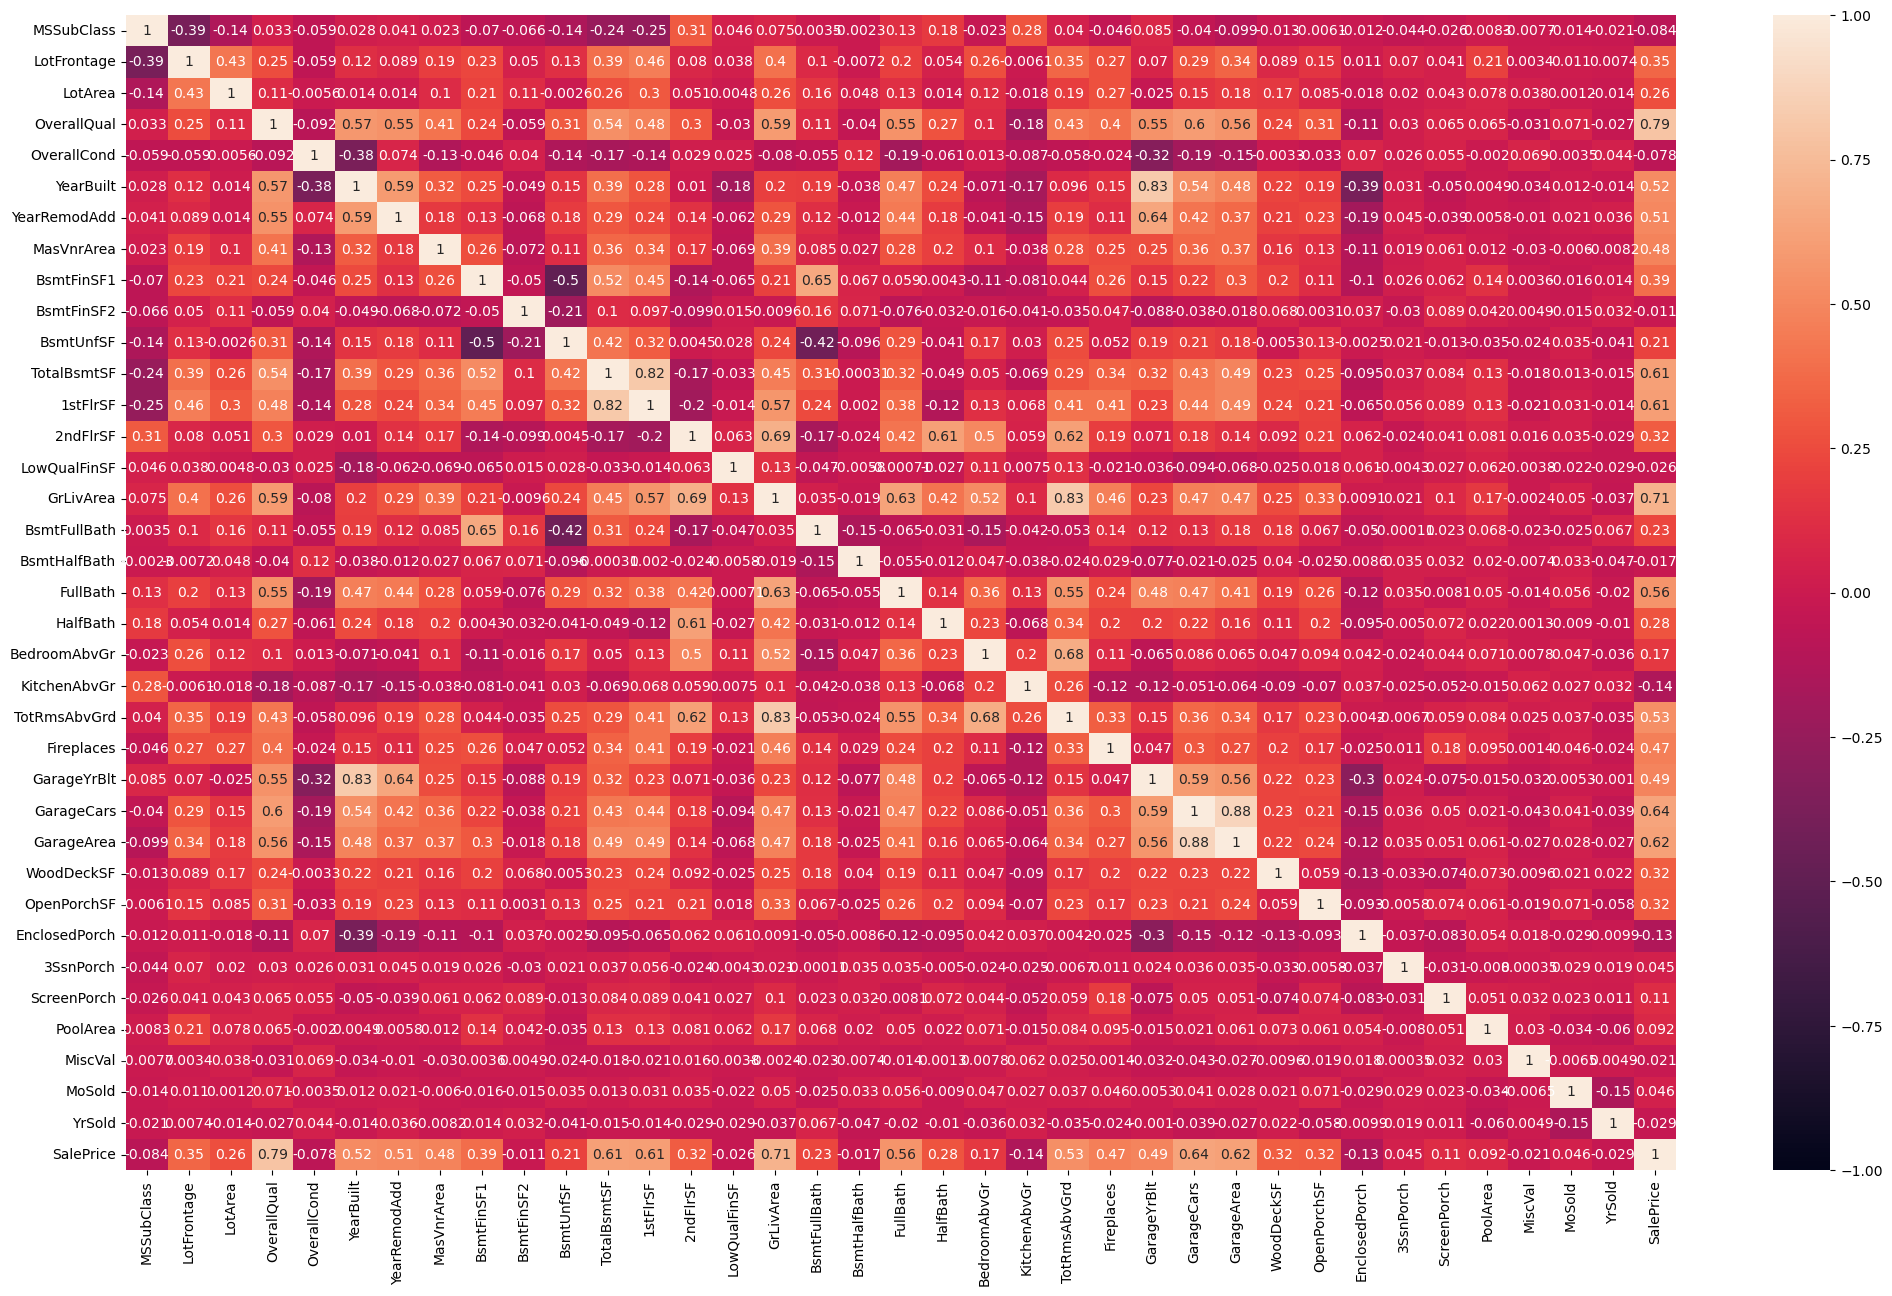

In [42]:
df_heatmap = X[Numeric]
fig, ax = plt.subplots(figsize=(25,15))
ax = sns.heatmap(df_heatmap.corr(),vmin=-1,vmax=1,annot=True)

{'whiskers': [<matplotlib.lines.Line2D at 0x2134cc03290>,
 'caps': [<matplotlib.lines.Line2D at 0x2134cc92c90>,
 'boxes': [<matplotlib.lines.Line2D at 0x2134cc91410>],
 'medians': [<matplotlib.lines.Line2D at 0x2134cc93e50>],
 'fliers': [<matplotlib.lines.Line2D at 0x2134cca8710>],
 'means': []}

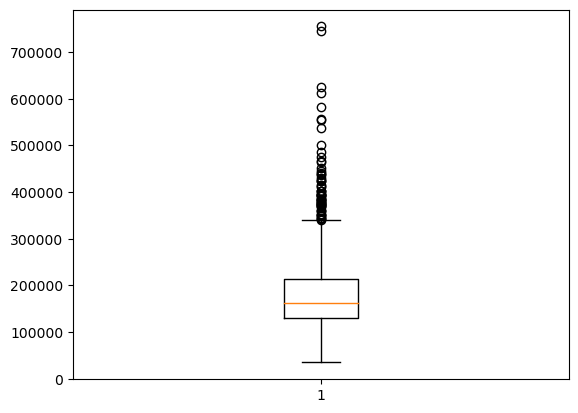

In [167]:
plt.boxplot(X['SalePrice'])

In [5]:
#object to rank encode
rank_obj_col = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
                'HeatingQC', 'KitchenQual',
                'GarageQual', 'GarageCond']

Z = pd.concat([X, X_test_full]).drop(labels=['SalePrice'], axis=1)

#object columns for OneHotEncoder
high_obj_col = [c for c in Z.columns if Z[c].dtype in ['object'] and Z[c].nunique() >= 10]
high_col_miss = [c for c in Z.columns if Z[c].dtype in ['object'] and Z[c].nunique() >= 10 and Z[c].isnull().any()]
low_obj_col = [c for c in X.columns if X[c].dtype in ['object'] and X[c].nunique() < 10]
Obj_col_miss = [c for c in X.columns if X[c].dtype in ['object'] and X[c].nunique() < 10 and X[c].isnull().any()]
Obj_col_full = [set(low_obj_col) - set(Obj_col_miss)]

#numeric columns
Num_cols = [c for c in Z.columns if Z[c].dtype in ['int64', 'float64']]
Num_cols_miss = [c for c in X.columns if X[c].dtype in ['int64', 'float64'] and (X[c].isnull().any())] 
Num_cols_full = [set(Num_cols) - set(Num_cols_miss)]

# Preproccesing methods for all algorithms

In [6]:
#function to cast string columns to float and delete unwanted columns
def ChangeAmbigouosColumns(x):
    G = x.copy(deep=True)
    G['MasVnrArea'] = G['MasVnrArea'].astype(str).astype(float)
    G.drop(high_obj_col, axis=1, inplace=True)
    return G

In [7]:
#make rank difference between features values
def EncodeRanking(x):
    for i in ('ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
              'HeatingQC', 'KitchenQual',
              'GarageQual', 'GarageCond'):
        x[i].replace(['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], [7, 6, 4, 3, 1, 0], inplace=True)

In [8]:
#work wirh Neughborhood
SquareFeet = X.groupby(['Neighborhood']).apply(lambda x: x['SalePrice'].sum() / x['LotArea'].sum()).reset_index(name='SquareFeetCost')
max = SquareFeet['SquareFeetCost'].max() + 1
min = SquareFeet['SquareFeetCost'].min() - 1
interval =  max - min + 1
step = interval / 5
SquareFeet.loc[SquareFeet['SquareFeetCost'] < min + step, 'rank'] = '1'
SquareFeet.loc[(SquareFeet['SquareFeetCost'] >= min + step)&(SquareFeet['SquareFeetCost'] < min + step*2), 'rank'] = '2'
SquareFeet.loc[(SquareFeet['SquareFeetCost'] >= min + step*2)&(SquareFeet['SquareFeetCost'] < min + step*3), 'rank'] = '3'
SquareFeet.loc[(SquareFeet['SquareFeetCost'] >= min + step*3)&(SquareFeet['SquareFeetCost'] < min + step*4), 'rank'] = '4'
SquareFeet.loc[SquareFeet['SquareFeetCost'] >= min + step*4, 'rank'] = '5'
SquareFeet.drop(labels=('SquareFeetCost'), axis=1, inplace=True)

def EncodeHighObj(x,case='default'):
    if case == 'default':
        G = pd.concat([x, X['Neighborhood']], axis=1)
        G = G.join(SquareFeet.set_index('Neighborhood'), on='Neighborhood')
        G.drop(labels=['Neighborhood'], axis=1, inplace=True)       
    else:
        G = pd.concat([x, X_test_full['Neighborhood']], axis=1)
        G = G.join(SquareFeet.set_index('Neighborhood'), on='Neighborhood')
        G.drop(labels=['Neighborhood'], axis=1, inplace=True)    
    return G

In [9]:
# Feature Engeneering
def FeatureEngeniring(s):
    x = s.copy(deep=True)
    x['HasPool'] = x['PoolArea'].apply(lambda x:1 if x > 0 else 0)
    x['HasSecondFloor'] = x['2ndFlrSF'].apply(lambda x:1 if x > 0 else 0)
    x['HasFirePlace'] = x['Fireplaces'].apply(lambda x:1 if x > 0 else 0)
    x['HasMiscFeature'] = x['MiscFeature'].apply(lambda x:0 if pd.isnull(x)  else 1)
    x['SoldInBuldYear'] = x['YrSold'] - x['YearBuilt'] < 2
    x['SoldInBuldYear'].replace({False: 0, True: 1}, inplace=True)
    
    x['TotalBathsFeet'] = x['BsmtFullBath']+x['BsmtHalfBath']+x['FullBath']+x['HalfBath'] 
    #x['BathsAmount'] = (x['BsmtFullBath'] > 0)*1 + (x['BsmtHalfBath'] > 0)*1 + (x['FullBath'] > 0)*1 + (x['HalfBath'] > 0)*1
    #x.drop(labels=['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'], axis=1, inplace=True)
    
    #x['TotalSquare'] = x['1stFlrSF']+x['2ndFlrSF']
    #x['TotalBath'] = (x['FullBath'] + x['HalfBath'] + x['BsmtFullBath'] + x['BsmtHalfBath'])
    #x['HasBsmnt'] = x['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    #x['RecentRemodel'] = (x["YrSold"] - x["YearRemodAdd"] < 6)*1
    #x.apply(lambda x:1 if x['YrSold'] - x['YearBuilt'] < 2 else 0)
    #x['HasAlley'] = x['Alley'].apply(lambda x: 0 if pd.isnull(x) else 1)
    #x['HasFence'] = x['Fence'].apply(lambda x: 0 if pd.isnull(x) else 1)
    x.drop(labels=['PoolArea', 'PoolQC', 'MiscFeature'], axis=1, inplace=True)
    return x

# Preproccesing methods for CatBoost

In [63]:
def FillMissingValues(x):
    f = x.copy(deep=True)
    #Object columns excluded PoolQc'

    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',
           'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'MiscFeature', 'Fence', 'Alley'):
        f[col].fillna('NA', inplace=True)
        
    #Numeric columns    
    for col in ('LotFrontage', 'MasVnrArea'):
        f[col].fillna(f[col].mean(), inplace=True)
    for col in (list(set(Num_cols))):
        f[col].fillna(0, inplace=True)
        
    #Single columns
    f['Electrical'].fillna(value=f[~f['Electrical'].isnull()]['Electrical'].mode()[0], inplace=True)
    f['Exterior1st'].fillna(value=f[~f['Exterior1st'].isnull()]['Exterior1st'].mode()[0], inplace=True)
    f['MasVnrType'].fillna('None', inplace=True)     
    f['GarageYrBlt'].fillna(f['GarageYrBlt'].median(), inplace=True)
    
    for col in ('SaleType', 'Functional', 'Utilities', 'MSZoning', 'KitchenQual'):
        f[col].fillna(f[col].mode()[0], inplace=True)
            
    return f

In [54]:
def EncodeTypeToCategory(x, f='default'):
    low = [c for c in x.columns if x[c].dtype in ['object'] ]
    for col in low:
        x[col] = x[col].astype('string')
    return x.columns.get_indexer(low)

In [55]:
#function to cast string columns to float and delete unwanted columns
def ChangeAmbigouosColumnsCatBoost(x):
    G = x.copy(deep=True)
    G['MasVnrArea'] = G['MasVnrArea'].astype(str).astype(float)
    G.drop(labels=['Neighborhood','Exterior2nd'], axis=1, inplace=True)
    return G

# Preproccesing methods for XGBRegressor

In [13]:
def FillMissingValuesXGBRregressor(x):
    f = x.copy(deep=True)
    #Object columns excluded PoolQc'

    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',
           'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'MiscFeature', 'Fence', 'Alley'):
        f[col].fillna('NA', inplace=True)
        
    #Numeric columns    
    for col in ('LotFrontage', 'MasVnrArea'):
        f[col].fillna(f[col].mean(), inplace=True)
    for col in (list(set(Num_cols))):
        f[col].fillna(0, inplace=True)
        
    #Single columns
    f['Electrical'].fillna(value=f[~f['Electrical'].isnull()]['Electrical'].mode()[0], inplace=True)
    f['MasVnrType'].fillna('None', inplace=True)     
    f['GarageYrBlt'].fillna(f['GarageYrBlt'].median(), inplace=True)
            
    return f

In [14]:
def EncodeObjectColumns(x, case='default'):
    low = [c for c in x.columns if x[c].dtype in ['object'] and x[c].nunique() < 10]
    encoding_cols = list(set(low) - set(rank_obj_col))
    if case == 'default':
        OH_X = pd.DataFrame(OH_encoder.fit_transform(x[encoding_cols]))
    else:
        OH_X = pd.DataFrame(OH_encoder.transform(x[encoding_cols]))
    OH_X.index = x.index
    Xret = pd.concat([x.drop(encoding_cols, axis=1), OH_X], axis=1)
    return Xret

# Make dataset for CatBoost

In [199]:
Cat_x = X.drop(labels='SalePrice', axis=1)
Xn_y = X['SalePrice']

In [200]:
Cat_x = FillMissingValues(Cat_x) #Just fill missing values
Cat_x = FeatureEngeniring(Cat_x) # Makee binary or numeric features 
Cat_x = ChangeAmbigouosColumnsCatBoost(Cat_x) #Encode wrong object to numeric and delete high object columns
Cat_x = EncodeHighObj(Cat_x) #Make mean cost of square feet from house location
EncodeRanking(Cat_x) # Range those features which has rank-logic
cat_features = EncodeTypeToCategory(Cat_x)
Cat_x.shape

(1460, 81)

In [201]:
weights = Xn_y.apply(lambda x:2 if x > 320000 else 1)

In [202]:
X_train_full, X_valid_full, y_train, y_valid = train_test_split(Cat_x, Xn_y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

### Search best n_estimators for CatBoost

In [203]:
cb = CatBoostRegressor(eval_metric='MAE',
                       random_seed=100234,
                       metric_period=10,
                       iterations=1500,
                       od_type='Iter',
                       od_wait=30
                      )

In [204]:
cb.fit(X_train_full, 
       y_train, plot=True, 
       eval_set=(X_valid_full, y_valid), 
       cat_features=cat_features)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.040744
0:	learn: 55906.5391795	test: 55500.4291407	best: 55500.4291407 (0)	total: 43.2ms	remaining: 1m 4s


10:	learn: 42465.1169408	test: 42558.6001149	best: 42558.6001149 (10)	total: 506ms	remaining: 1m 8s
20:	learn: 33354.5035879	test: 34078.0142827	best: 34078.0142827 (20)	total: 979ms	remaining: 1m 8s
30:	learn: 26839.3193353	test: 28223.2946539	best: 28223.2946539 (30)	total: 1.51s	remaining: 1m 11s
40:	learn: 22597.1090584	test: 24397.1633020	best: 24397.1633020 (40)	total: 1.98s	remaining: 1m 10s
50:	learn: 19787.5922011	test: 22077.4035420	best: 22077.4035420 (50)	total: 2.48s	remaining: 1m 10s
60:	learn: 18023.3662417	test: 20646.3984329	best: 20646.3984329 (60)	total: 2.96s	remaining: 1m 9s
70:	learn: 16905.8025092	test: 19894.0860990	best: 19894.0860990 (70)	total: 3.42s	remaining: 1m 8s
80:	learn: 16068.6729180	test: 19269.4647244	best: 19269.4647244 (80)	total: 3.89s	remaining: 1m 8s
90:	learn: 15406.4420394	test: 18774.0892867	best: 18774.0892867 (90)	total: 4.42s	remaining: 1m 8s
100:	learn: 14922.0077664	test: 18525.6126085	best: 18525.6126085 (100)	total: 4.91s	remaining: 1

### Teach CatBosst with best n_estimators value

In [205]:
cb = CatBoostRegressor(eval_metric='MAE',
                       random_seed=100234,
                       iterations=1400
                      )
cb.fit(Cat_x, Xn_y, cat_features=cat_features,
       sample_weight=weights)

Learning rate set to 0.033063
0:	learn: 67057.3861069	total: 40.2ms	remaining: 56.3s
1:	learn: 65469.8406785	total: 80.1ms	remaining: 56s
2:	learn: 63817.5758979	total: 118ms	remaining: 54.7s
3:	learn: 62280.5882865	total: 160ms	remaining: 55.7s
4:	learn: 60647.4600322	total: 202ms	remaining: 56.3s
5:	learn: 59080.7493810	total: 249ms	remaining: 57.9s
6:	learn: 57667.6207061	total: 294ms	remaining: 58.5s
7:	learn: 56238.6172108	total: 342ms	remaining: 59.5s
8:	learn: 55001.2137583	total: 390ms	remaining: 1m
9:	learn: 53759.0439185	total: 437ms	remaining: 1m
10:	learn: 52655.6183572	total: 487ms	remaining: 1m 1s
11:	learn: 51505.3955811	total: 533ms	remaining: 1m 1s
12:	learn: 50210.1036429	total: 578ms	remaining: 1m 1s
13:	learn: 49073.0780884	total: 621ms	remaining: 1m 1s
14:	learn: 48004.0465289	total: 663ms	remaining: 1m 1s
15:	learn: 46837.4241226	total: 705ms	remaining: 1m 1s
16:	learn: 45783.4904128	total: 750ms	remaining: 1m 1s
17:	learn: 44820.0275476	total: 794ms	remaining: 1m

151:	learn: 14939.5712204	total: 7.28s	remaining: 59.8s
152:	learn: 14905.8771249	total: 7.33s	remaining: 59.7s
153:	learn: 14906.0111343	total: 7.34s	remaining: 59.4s
154:	learn: 14883.1720206	total: 7.39s	remaining: 59.4s
155:	learn: 14866.1342893	total: 7.43s	remaining: 59.3s
156:	learn: 14834.4358255	total: 7.48s	remaining: 59.2s
157:	learn: 14834.5118454	total: 7.49s	remaining: 58.9s
158:	learn: 14806.6242568	total: 7.54s	remaining: 58.8s
159:	learn: 14757.8262782	total: 7.58s	remaining: 58.8s
160:	learn: 14720.8096802	total: 7.62s	remaining: 58.7s
161:	learn: 14705.1571680	total: 7.67s	remaining: 58.6s
162:	learn: 14670.7938226	total: 7.71s	remaining: 58.5s
163:	learn: 14644.0974485	total: 7.76s	remaining: 58.5s
164:	learn: 14619.8927934	total: 7.81s	remaining: 58.4s
165:	learn: 14602.4083877	total: 7.85s	remaining: 58.4s
166:	learn: 14573.4548714	total: 7.9s	remaining: 58.3s
167:	learn: 14548.5097824	total: 7.94s	remaining: 58.3s
168:	learn: 14512.3411859	total: 7.99s	remaining:

302:	learn: 12383.3265568	total: 14.3s	remaining: 51.7s
303:	learn: 12376.3224882	total: 14.3s	remaining: 51.7s
304:	learn: 12356.4278526	total: 14.4s	remaining: 51.6s
305:	learn: 12351.9414478	total: 14.4s	remaining: 51.6s
306:	learn: 12347.3224824	total: 14.5s	remaining: 51.5s
307:	learn: 12329.6419892	total: 14.5s	remaining: 51.5s
308:	learn: 12321.8741526	total: 14.6s	remaining: 51.4s
309:	learn: 12317.3547777	total: 14.6s	remaining: 51.4s
310:	learn: 12295.3016945	total: 14.7s	remaining: 51.3s
311:	learn: 12271.2342453	total: 14.7s	remaining: 51.3s
312:	learn: 12261.2192375	total: 14.7s	remaining: 51.2s
313:	learn: 12257.7690572	total: 14.8s	remaining: 51.2s
314:	learn: 12253.3277586	total: 14.8s	remaining: 51.1s
315:	learn: 12249.0142815	total: 14.9s	remaining: 51.1s
316:	learn: 12233.3118159	total: 14.9s	remaining: 51s
317:	learn: 12206.7162699	total: 15s	remaining: 51s
318:	learn: 12200.9549875	total: 15s	remaining: 50.9s
319:	learn: 12182.7896695	total: 15.1s	remaining: 50.9s


451:	learn: 10779.9100230	total: 21.6s	remaining: 45.3s
452:	learn: 10766.0559213	total: 21.7s	remaining: 45.3s
453:	learn: 10761.2279508	total: 21.7s	remaining: 45.2s
454:	learn: 10753.3187538	total: 21.8s	remaining: 45.2s
455:	learn: 10747.4142265	total: 21.8s	remaining: 45.2s
456:	learn: 10732.5693803	total: 21.9s	remaining: 45.1s
457:	learn: 10730.1654427	total: 21.9s	remaining: 45.1s
458:	learn: 10722.9445890	total: 22s	remaining: 45s
459:	learn: 10719.6606220	total: 22s	remaining: 45s
460:	learn: 10713.8302871	total: 22.1s	remaining: 45s
461:	learn: 10704.9719612	total: 22.1s	remaining: 44.9s
462:	learn: 10689.8826734	total: 22.2s	remaining: 44.9s
463:	learn: 10676.0999344	total: 22.2s	remaining: 44.8s
464:	learn: 10672.3433542	total: 22.3s	remaining: 44.8s
465:	learn: 10665.8939618	total: 22.3s	remaining: 44.7s
466:	learn: 10662.3424868	total: 22.4s	remaining: 44.7s
467:	learn: 10646.6712061	total: 22.4s	remaining: 44.6s
468:	learn: 10636.8866974	total: 22.4s	remaining: 44.6s
46

602:	learn: 9490.4213444	total: 29s	remaining: 38.4s
603:	learn: 9482.3570692	total: 29.1s	remaining: 38.3s
604:	learn: 9472.7242919	total: 29.1s	remaining: 38.3s
605:	learn: 9470.1124179	total: 29.2s	remaining: 38.2s
606:	learn: 9465.0885152	total: 29.2s	remaining: 38.2s
607:	learn: 9463.3240037	total: 29.3s	remaining: 38.1s
608:	learn: 9461.4651912	total: 29.3s	remaining: 38.1s
609:	learn: 9454.9423816	total: 29.4s	remaining: 38s
610:	learn: 9452.9664656	total: 29.4s	remaining: 38s
611:	learn: 9452.5719866	total: 29.5s	remaining: 37.9s
612:	learn: 9450.6133401	total: 29.5s	remaining: 37.9s
613:	learn: 9446.8554857	total: 29.6s	remaining: 37.8s
614:	learn: 9435.5034092	total: 29.6s	remaining: 37.8s
615:	learn: 9432.5147851	total: 29.7s	remaining: 37.7s
616:	learn: 9428.0915876	total: 29.7s	remaining: 37.7s
617:	learn: 9427.5204179	total: 29.7s	remaining: 37.6s
618:	learn: 9420.9091051	total: 29.8s	remaining: 37.6s
619:	learn: 9416.7671082	total: 29.8s	remaining: 37.5s
620:	learn: 9411

756:	learn: 8533.1144590	total: 36.4s	remaining: 30.9s
757:	learn: 8529.5295596	total: 36.4s	remaining: 30.9s
758:	learn: 8523.9164427	total: 36.5s	remaining: 30.8s
759:	learn: 8522.9673782	total: 36.5s	remaining: 30.8s
760:	learn: 8520.8256901	total: 36.6s	remaining: 30.7s
761:	learn: 8515.1995699	total: 36.6s	remaining: 30.7s
762:	learn: 8504.6279041	total: 36.7s	remaining: 30.6s
763:	learn: 8502.0834858	total: 36.7s	remaining: 30.6s
764:	learn: 8498.2183457	total: 36.8s	remaining: 30.5s
765:	learn: 8492.8586285	total: 36.8s	remaining: 30.5s
766:	learn: 8485.7253731	total: 36.9s	remaining: 30.4s
767:	learn: 8478.9068565	total: 36.9s	remaining: 30.4s
768:	learn: 8476.2102871	total: 37s	remaining: 30.3s
769:	learn: 8467.2673147	total: 37s	remaining: 30.3s
770:	learn: 8463.6436550	total: 37.1s	remaining: 30.2s
771:	learn: 8456.9310902	total: 37.1s	remaining: 30.2s
772:	learn: 8452.0007014	total: 37.2s	remaining: 30.1s
773:	learn: 8449.7453237	total: 37.2s	remaining: 30.1s
774:	learn: 84

908:	learn: 7811.2914381	total: 44.2s	remaining: 23.8s
909:	learn: 7807.3968700	total: 44.2s	remaining: 23.8s
910:	learn: 7805.3909774	total: 44.3s	remaining: 23.8s
911:	learn: 7793.3881731	total: 44.3s	remaining: 23.7s
912:	learn: 7792.4414031	total: 44.4s	remaining: 23.7s
913:	learn: 7783.0289638	total: 44.4s	remaining: 23.6s
914:	learn: 7774.3384664	total: 44.5s	remaining: 23.6s
915:	learn: 7774.1919167	total: 44.5s	remaining: 23.5s
916:	learn: 7768.7950426	total: 44.6s	remaining: 23.5s
917:	learn: 7768.6624961	total: 44.6s	remaining: 23.4s
918:	learn: 7765.6915732	total: 44.7s	remaining: 23.4s
919:	learn: 7761.7521212	total: 44.7s	remaining: 23.3s
920:	learn: 7755.3376352	total: 44.8s	remaining: 23.3s
921:	learn: 7750.4316022	total: 44.8s	remaining: 23.2s
922:	learn: 7749.5661036	total: 44.9s	remaining: 23.2s
923:	learn: 7738.3184313	total: 44.9s	remaining: 23.2s
924:	learn: 7734.6429672	total: 45s	remaining: 23.1s
925:	learn: 7731.6324900	total: 45s	remaining: 23.1s
926:	learn: 77

1058:	learn: 7285.6722979	total: 51.5s	remaining: 16.6s
1059:	learn: 7284.6327918	total: 51.5s	remaining: 16.5s
1060:	learn: 7284.3648841	total: 51.6s	remaining: 16.5s
1061:	learn: 7281.8371151	total: 51.6s	remaining: 16.4s
1062:	learn: 7279.9130222	total: 51.7s	remaining: 16.4s
1063:	learn: 7274.4291097	total: 51.7s	remaining: 16.3s
1064:	learn: 7265.6851117	total: 51.8s	remaining: 16.3s
1065:	learn: 7265.0395246	total: 51.8s	remaining: 16.2s
1066:	learn: 7264.6934444	total: 51.9s	remaining: 16.2s
1067:	learn: 7257.8233112	total: 51.9s	remaining: 16.1s
1068:	learn: 7248.8312783	total: 52s	remaining: 16.1s
1069:	learn: 7247.4785993	total: 52s	remaining: 16s
1070:	learn: 7244.0286231	total: 52.1s	remaining: 16s
1071:	learn: 7234.4326050	total: 52.1s	remaining: 15.9s
1072:	learn: 7226.2733527	total: 52.2s	remaining: 15.9s
1073:	learn: 7220.2910859	total: 52.2s	remaining: 15.8s
1074:	learn: 7213.5865039	total: 52.2s	remaining: 15.8s
1075:	learn: 7205.8952065	total: 52.3s	remaining: 15.7s


1209:	learn: 6727.2226788	total: 59s	remaining: 9.27s
1210:	learn: 6723.3858308	total: 59.1s	remaining: 9.22s
1211:	learn: 6722.8237583	total: 59.2s	remaining: 9.18s
1212:	learn: 6718.1219379	total: 59.2s	remaining: 9.13s
1213:	learn: 6710.5609688	total: 59.3s	remaining: 9.08s
1214:	learn: 6709.0076850	total: 59.3s	remaining: 9.03s
1215:	learn: 6706.3545172	total: 59.4s	remaining: 8.99s
1216:	learn: 6704.1598691	total: 59.4s	remaining: 8.94s
1217:	learn: 6704.0584364	total: 59.5s	remaining: 8.89s
1218:	learn: 6701.4516744	total: 59.5s	remaining: 8.84s
1219:	learn: 6694.6001875	total: 59.6s	remaining: 8.79s
1220:	learn: 6690.9475983	total: 59.7s	remaining: 8.74s
1221:	learn: 6680.3055930	total: 59.7s	remaining: 8.7s
1222:	learn: 6676.3923075	total: 59.8s	remaining: 8.65s
1223:	learn: 6672.7185245	total: 59.8s	remaining: 8.6s
1224:	learn: 6670.8936043	total: 59.9s	remaining: 8.55s
1225:	learn: 6664.7692258	total: 59.9s	remaining: 8.5s
1226:	learn: 6659.1857625	total: 60s	remaining: 8.46s

1357:	learn: 6248.3834450	total: 1m 6s	remaining: 2.06s
1358:	learn: 6246.8466306	total: 1m 6s	remaining: 2.01s
1359:	learn: 6243.7502072	total: 1m 6s	remaining: 1.96s
1360:	learn: 6243.2079745	total: 1m 6s	remaining: 1.91s
1361:	learn: 6241.8540096	total: 1m 6s	remaining: 1.86s
1362:	learn: 6237.6808887	total: 1m 6s	remaining: 1.81s
1363:	learn: 6233.7384604	total: 1m 6s	remaining: 1.76s
1364:	learn: 6227.0901597	total: 1m 6s	remaining: 1.72s
1365:	learn: 6224.1171400	total: 1m 6s	remaining: 1.67s
1366:	learn: 6223.0984503	total: 1m 7s	remaining: 1.62s
1367:	learn: 6218.1021728	total: 1m 7s	remaining: 1.57s
1368:	learn: 6216.4687629	total: 1m 7s	remaining: 1.52s
1369:	learn: 6214.7632857	total: 1m 7s	remaining: 1.47s
1370:	learn: 6214.3144497	total: 1m 7s	remaining: 1.42s
1371:	learn: 6211.8815324	total: 1m 7s	remaining: 1.37s
1372:	learn: 6211.2479346	total: 1m 7s	remaining: 1.32s
1373:	learn: 6210.3188191	total: 1m 7s	remaining: 1.27s
1374:	learn: 6206.4067979	total: 1m 7s	remaining

In [201]:
#Last6199 learn and 13490 in submission
#Last6150 learn and 13377 in submission
#Last6143 learn and 13240 in submission (with weights for )

In [206]:
CatTest = FillMissingValues(X_test_full)
CatTest = FeatureEngeniring(CatTest)
CatTest = ChangeAmbigouosColumnsCatBoost(CatTest)
CatTest = EncodeHighObj(CatTest,'f')
EncodeRanking(CatTest)
EncodeTypeToCategory(CatTest)
cat_pred = cb.predict(CatTest)

In [207]:
cat_pred

array([117863.62495267, 165842.35223237, 183452.0872942 , ...,
       167845.77660924, 116458.52954103, 222600.9380644 ])

In [206]:
output = pd.DataFrame({'Id': X_test_full.index,
                       'SalePrice': cat_pred})
output.to_csv(r'C:\\Users\\ntopl\\Downloads\\submission.csv', index= False )

### Make common Dataset for XGBRegressor and Catboost

In [189]:
Xn_x = X.drop(labels='SalePrice', axis=1)
Xn_y = X['SalePrice']

In [190]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
Xn = FillMissingValuesXGBRregressor(Xn_x)
Xn = FeatureEngeniring(Xn)
Xn = ChangeAmbigouosColumns(Xn)
Xn = EncodeHighObj(Xn)
Xn = EncodeObjectColumns(Xn)
EncodeRanking(Xn)
Xn.shape

C:\Users\ntopl\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(1460, 215)

In [192]:
Xtest = FillMissingValuesXGBRregressor(X_test_full)
Xtest = FeatureEngeniring(Xtest)
Xtest = ChangeAmbigouosColumns(Xtest)
Xtest = EncodeHighObj(Xtest,'f')
Xtest = EncodeObjectColumns(Xtest,case='f')
EncodeRanking(Xtest)

# Searching Parameters for XGBRegressor

In [47]:
import time
start_time = time.time()

parameters = { 'max_depth': [n for n in range(3, 7, 1)],
               'min_child_weight': [n for n in range(1, 5, 1)],
               'subsample': [x/10 for x in range(5, 10, 1)],
               'colsample_bytree': [x/10 for x in range(2, 10, 1)]
             }

clf = XGBRegressor(random_state=0, n_estimators=20)
grid = GridSearchCV(clf, parameters, cv=5, scoring='neg_mean_absolute_error')
grid.fit(Xn, Xn_y)

end_time = time.time()
execution_time = end_time - start_time
print(f"Время выполнения программы: {execution_time} секунд")

Время выполнения программы: 519.6645681858063 секунд


In [48]:
parameters['max_depth'] = [grid.best_params_['max_depth']]
parameters['min_child_weight'] = [grid.best_params_['min_child_weight']]
parameters['subsample'] = [grid.best_params_['subsample']]
parameters['colsample_bytree'] = [grid.best_params_['colsample_bytree']]

In [49]:
print(grid.best_params_)
print(grid.best_score_)

{'colsample_bytree': 0.7, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.9}
-16979.178245398118


In [50]:
parameters['learning_rate'] = [x/100 for x in range(1, 7, 5)]
parameters['n_estimators'] = [x for x in range(950, 1001, 10)]
grid.fit(Xn, Xn_y)
parameters['learning_rate'] = [grid.best_params_['learning_rate']]
parameters['n_estimators'] = [grid.best_params_['n_estimators']]

In [51]:
print(grid.best_params_)
print(grid.best_score_)

{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 1000, 'subsample': 0.9}
-15335.121176690922


In [193]:
my_model = XGBRegressor(random_state=0, n_estimators=5000, learning_rate=0.01, colsample_bytree=0.7,
                          min_child_weight=2, subsample=0.9, max_depth=5)
my_model.fit(Xn, Xn_y, early_stopping_rounds=5, eval_set=[(Xn, Xn_y)])

[0]	validation_0-rmse:78785.57308
[1]	validation_0-rmse:78149.63398
[2]	validation_0-rmse:77518.12634
[3]	validation_0-rmse:76895.32115
[4]	validation_0-rmse:76270.90191
[5]	validation_0-rmse:75669.60490
[6]	validation_0-rmse:75088.83793
[7]	validation_0-rmse:74507.28430
[8]	validation_0-rmse:73921.46592
[9]	validation_0-rmse:73343.51717
[10]	validation_0-rmse:72770.00526
[11]	validation_0-rmse:72203.23008
[12]	validation_0-rmse:71649.53724
[13]	validation_0-rmse:71086.43875
[14]	validation_0-rmse:70536.47662
[15]	validation_0-rmse:69984.98453
[16]	validation_0-rmse:69458.00160
[17]	validation_0-rmse:68902.56418
[18]	validation_0-rmse:68372.93124
[19]	validation_0-rmse:67841.67396
[20]	validation_0-rmse:67331.05746
[21]	validation_0-rmse:66817.13475
[22]	validation_0-rmse:66323.87120
[23]	validation_0-rmse:65817.88722
[24]	validation_0-rmse:65309.36989
[25]	validation_0-rmse:64797.35539
[26]	validation_0-rmse:64297.45944
[27]	validation_0-rmse:63796.34402
[28]	validation_0-rmse:63337.5

C:\Users\ntopl\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[33]	validation_0-rmse:60983.78004
[34]	validation_0-rmse:60520.37341
[35]	validation_0-rmse:60058.75488
[36]	validation_0-rmse:59605.74165
[37]	validation_0-rmse:59160.72626
[38]	validation_0-rmse:58715.04811
[39]	validation_0-rmse:58283.66053
[40]	validation_0-rmse:57855.26779
[41]	validation_0-rmse:57442.33819
[42]	validation_0-rmse:57014.83437
[43]	validation_0-rmse:56603.53342
[44]	validation_0-rmse:56200.38581
[45]	validation_0-rmse:55784.15018
[46]	validation_0-rmse:55389.77724
[47]	validation_0-rmse:54979.74488
[48]	validation_0-rmse:54579.97185
[49]	validation_0-rmse:54188.75721
[50]	validation_0-rmse:53795.61352
[51]	validation_0-rmse:53405.62422
[52]	validation_0-rmse:53028.83664
[53]	validation_0-rmse:52660.98980
[54]	validation_0-rmse:52275.72402
[55]	validation_0-rmse:51897.27459
[56]	validation_0-rmse:51538.15382
[57]	validation_0-rmse:51169.02621
[58]	validation_0-rmse:50799.13792
[59]	validation_0-rmse:50435.18129
[60]	validation_0-rmse:50084.95499
[61]	validation_0-rm

[263]	validation_0-rmse:17750.73944
[264]	validation_0-rmse:17693.56658
[265]	validation_0-rmse:17637.58258
[266]	validation_0-rmse:17575.11147
[267]	validation_0-rmse:17518.83170
[268]	validation_0-rmse:17466.19534
[269]	validation_0-rmse:17416.00266
[270]	validation_0-rmse:17358.94709
[271]	validation_0-rmse:17305.62596
[272]	validation_0-rmse:17249.83399
[273]	validation_0-rmse:17196.15759
[274]	validation_0-rmse:17142.42884
[275]	validation_0-rmse:17093.48302
[276]	validation_0-rmse:17043.82251
[277]	validation_0-rmse:16995.30527
[278]	validation_0-rmse:16941.61929
[279]	validation_0-rmse:16890.25913
[280]	validation_0-rmse:16838.51352
[281]	validation_0-rmse:16790.32426
[282]	validation_0-rmse:16745.69923
[283]	validation_0-rmse:16693.51507
[284]	validation_0-rmse:16640.17689
[285]	validation_0-rmse:16593.45791
[286]	validation_0-rmse:16545.69297
[287]	validation_0-rmse:16492.54921
[288]	validation_0-rmse:16449.29339
[289]	validation_0-rmse:16407.13804
[290]	validation_0-rmse:1635

[491]	validation_0-rmse:11605.42390
[492]	validation_0-rmse:11593.41945
[493]	validation_0-rmse:11584.32659
[494]	validation_0-rmse:11567.19643
[495]	validation_0-rmse:11556.36786
[496]	validation_0-rmse:11544.37222
[497]	validation_0-rmse:11534.08381
[498]	validation_0-rmse:11519.83294
[499]	validation_0-rmse:11509.74236
[500]	validation_0-rmse:11494.52669
[501]	validation_0-rmse:11484.45525
[502]	validation_0-rmse:11471.98911
[503]	validation_0-rmse:11460.20476
[504]	validation_0-rmse:11452.31465
[505]	validation_0-rmse:11441.11049
[506]	validation_0-rmse:11426.72502
[507]	validation_0-rmse:11414.78297
[508]	validation_0-rmse:11403.53168
[509]	validation_0-rmse:11394.07939
[510]	validation_0-rmse:11383.48775
[511]	validation_0-rmse:11369.95015
[512]	validation_0-rmse:11361.40367
[513]	validation_0-rmse:11352.74867
[514]	validation_0-rmse:11339.80233
[515]	validation_0-rmse:11330.42601
[516]	validation_0-rmse:11315.72381
[517]	validation_0-rmse:11305.36639
[518]	validation_0-rmse:1129

[720]	validation_0-rmse:9727.86495
[721]	validation_0-rmse:9723.11244
[722]	validation_0-rmse:9718.57962
[723]	validation_0-rmse:9712.60988
[724]	validation_0-rmse:9708.92812
[725]	validation_0-rmse:9699.59352
[726]	validation_0-rmse:9693.13144
[727]	validation_0-rmse:9687.80495
[728]	validation_0-rmse:9683.92769
[729]	validation_0-rmse:9678.08377
[730]	validation_0-rmse:9675.55980
[731]	validation_0-rmse:9669.55901
[732]	validation_0-rmse:9662.92410
[733]	validation_0-rmse:9656.15372
[734]	validation_0-rmse:9651.40290
[735]	validation_0-rmse:9644.37229
[736]	validation_0-rmse:9640.35761
[737]	validation_0-rmse:9633.18985
[738]	validation_0-rmse:9624.65498
[739]	validation_0-rmse:9619.51626
[740]	validation_0-rmse:9614.99283
[741]	validation_0-rmse:9609.83021
[742]	validation_0-rmse:9603.87953
[743]	validation_0-rmse:9600.25878
[744]	validation_0-rmse:9596.89817
[745]	validation_0-rmse:9593.08051
[746]	validation_0-rmse:9585.92447
[747]	validation_0-rmse:9582.51179
[748]	validation_0-r

[955]	validation_0-rmse:8528.71206
[956]	validation_0-rmse:8521.04076
[957]	validation_0-rmse:8517.05449
[958]	validation_0-rmse:8514.63980
[959]	validation_0-rmse:8509.96995
[960]	validation_0-rmse:8506.47866
[961]	validation_0-rmse:8502.63401
[962]	validation_0-rmse:8496.07543
[963]	validation_0-rmse:8489.23386
[964]	validation_0-rmse:8481.36139
[965]	validation_0-rmse:8473.81490
[966]	validation_0-rmse:8463.85339
[967]	validation_0-rmse:8458.51817
[968]	validation_0-rmse:8453.50708
[969]	validation_0-rmse:8446.42515
[970]	validation_0-rmse:8440.94747
[971]	validation_0-rmse:8437.01800
[972]	validation_0-rmse:8434.33116
[973]	validation_0-rmse:8430.48594
[974]	validation_0-rmse:8427.48077
[975]	validation_0-rmse:8423.14122
[976]	validation_0-rmse:8418.24479
[977]	validation_0-rmse:8416.73417
[978]	validation_0-rmse:8412.03850
[979]	validation_0-rmse:8408.99711
[980]	validation_0-rmse:8406.31209
[981]	validation_0-rmse:8400.65353
[982]	validation_0-rmse:8395.96525
[983]	validation_0-r

[1184]	validation_0-rmse:7521.76492
[1185]	validation_0-rmse:7515.43276
[1186]	validation_0-rmse:7511.28448
[1187]	validation_0-rmse:7509.32445
[1188]	validation_0-rmse:7505.32628
[1189]	validation_0-rmse:7500.21618
[1190]	validation_0-rmse:7498.55036
[1191]	validation_0-rmse:7494.64113
[1192]	validation_0-rmse:7488.63924
[1193]	validation_0-rmse:7484.76290
[1194]	validation_0-rmse:7480.83156
[1195]	validation_0-rmse:7475.90016
[1196]	validation_0-rmse:7471.80569
[1197]	validation_0-rmse:7468.07747
[1198]	validation_0-rmse:7464.10386
[1199]	validation_0-rmse:7458.72389
[1200]	validation_0-rmse:7457.03938
[1201]	validation_0-rmse:7451.85881
[1202]	validation_0-rmse:7450.32945
[1203]	validation_0-rmse:7448.49896
[1204]	validation_0-rmse:7445.61629
[1205]	validation_0-rmse:7444.31141
[1206]	validation_0-rmse:7441.48559
[1207]	validation_0-rmse:7436.67213
[1208]	validation_0-rmse:7431.47969
[1209]	validation_0-rmse:7426.93877
[1210]	validation_0-rmse:7422.63949
[1211]	validation_0-rmse:741

[1412]	validation_0-rmse:6713.20011
[1413]	validation_0-rmse:6710.48353
[1414]	validation_0-rmse:6708.66827
[1415]	validation_0-rmse:6705.24045
[1416]	validation_0-rmse:6703.82300
[1417]	validation_0-rmse:6699.06226
[1418]	validation_0-rmse:6697.09547
[1419]	validation_0-rmse:6693.96781
[1420]	validation_0-rmse:6692.03984
[1421]	validation_0-rmse:6688.96499
[1422]	validation_0-rmse:6686.67637
[1423]	validation_0-rmse:6682.65779
[1424]	validation_0-rmse:6677.76573
[1425]	validation_0-rmse:6675.31474
[1426]	validation_0-rmse:6672.07238
[1427]	validation_0-rmse:6667.16519
[1428]	validation_0-rmse:6660.71813
[1429]	validation_0-rmse:6655.65062
[1430]	validation_0-rmse:6653.29321
[1431]	validation_0-rmse:6649.86848
[1432]	validation_0-rmse:6645.80746
[1433]	validation_0-rmse:6642.42568
[1434]	validation_0-rmse:6638.46932
[1435]	validation_0-rmse:6634.27843
[1436]	validation_0-rmse:6631.51499
[1437]	validation_0-rmse:6627.43660
[1438]	validation_0-rmse:6623.70723
[1439]	validation_0-rmse:662

[1640]	validation_0-rmse:5983.24021
[1641]	validation_0-rmse:5979.07117
[1642]	validation_0-rmse:5976.56207
[1643]	validation_0-rmse:5975.96441
[1644]	validation_0-rmse:5972.17629
[1645]	validation_0-rmse:5970.47713
[1646]	validation_0-rmse:5966.72848
[1647]	validation_0-rmse:5962.70750
[1648]	validation_0-rmse:5961.81343
[1649]	validation_0-rmse:5958.94850
[1650]	validation_0-rmse:5955.91230
[1651]	validation_0-rmse:5954.55072
[1652]	validation_0-rmse:5951.36240
[1653]	validation_0-rmse:5950.68490
[1654]	validation_0-rmse:5949.32216
[1655]	validation_0-rmse:5944.36259
[1656]	validation_0-rmse:5941.02299
[1657]	validation_0-rmse:5939.08898
[1658]	validation_0-rmse:5934.85837
[1659]	validation_0-rmse:5930.21532
[1660]	validation_0-rmse:5927.89527
[1661]	validation_0-rmse:5924.80139
[1662]	validation_0-rmse:5919.65127
[1663]	validation_0-rmse:5917.14744
[1664]	validation_0-rmse:5915.27583
[1665]	validation_0-rmse:5912.45699
[1666]	validation_0-rmse:5908.46008
[1667]	validation_0-rmse:590

[1868]	validation_0-rmse:5357.78533
[1869]	validation_0-rmse:5354.02870
[1870]	validation_0-rmse:5352.65768
[1871]	validation_0-rmse:5350.18797
[1872]	validation_0-rmse:5347.23489
[1873]	validation_0-rmse:5345.31643
[1874]	validation_0-rmse:5343.02083
[1875]	validation_0-rmse:5340.43262
[1876]	validation_0-rmse:5338.29146
[1877]	validation_0-rmse:5336.30367
[1878]	validation_0-rmse:5334.05262
[1879]	validation_0-rmse:5330.43581
[1880]	validation_0-rmse:5326.56974
[1881]	validation_0-rmse:5324.28172
[1882]	validation_0-rmse:5320.97804
[1883]	validation_0-rmse:5318.92389
[1884]	validation_0-rmse:5316.32478
[1885]	validation_0-rmse:5312.50290
[1886]	validation_0-rmse:5310.64468
[1887]	validation_0-rmse:5306.53998
[1888]	validation_0-rmse:5304.48064
[1889]	validation_0-rmse:5302.50880
[1890]	validation_0-rmse:5298.72264
[1891]	validation_0-rmse:5294.75095
[1892]	validation_0-rmse:5291.22905
[1893]	validation_0-rmse:5290.04268
[1894]	validation_0-rmse:5284.70854
[1895]	validation_0-rmse:528

[2096]	validation_0-rmse:4813.47051
[2097]	validation_0-rmse:4811.24054
[2098]	validation_0-rmse:4808.26741
[2099]	validation_0-rmse:4806.99011
[2100]	validation_0-rmse:4804.30925
[2101]	validation_0-rmse:4801.70397
[2102]	validation_0-rmse:4798.61298
[2103]	validation_0-rmse:4796.21313
[2104]	validation_0-rmse:4793.71698
[2105]	validation_0-rmse:4791.25859
[2106]	validation_0-rmse:4787.94248
[2107]	validation_0-rmse:4786.36899
[2108]	validation_0-rmse:4784.16112
[2109]	validation_0-rmse:4781.89552
[2110]	validation_0-rmse:4780.28138
[2111]	validation_0-rmse:4776.96072
[2112]	validation_0-rmse:4773.06640
[2113]	validation_0-rmse:4770.19221
[2114]	validation_0-rmse:4769.49009
[2115]	validation_0-rmse:4768.02365
[2116]	validation_0-rmse:4765.36041
[2117]	validation_0-rmse:4762.26787
[2118]	validation_0-rmse:4760.05655
[2119]	validation_0-rmse:4757.95757
[2120]	validation_0-rmse:4756.66917
[2121]	validation_0-rmse:4756.00669
[2122]	validation_0-rmse:4753.46010
[2123]	validation_0-rmse:475

[2324]	validation_0-rmse:4322.94523
[2325]	validation_0-rmse:4319.88459
[2326]	validation_0-rmse:4319.28413
[2327]	validation_0-rmse:4318.49138
[2328]	validation_0-rmse:4316.49110
[2329]	validation_0-rmse:4315.25708
[2330]	validation_0-rmse:4312.75304
[2331]	validation_0-rmse:4312.01268
[2332]	validation_0-rmse:4310.65352
[2333]	validation_0-rmse:4307.65700
[2334]	validation_0-rmse:4306.93211
[2335]	validation_0-rmse:4305.97480
[2336]	validation_0-rmse:4304.25129
[2337]	validation_0-rmse:4302.35324
[2338]	validation_0-rmse:4301.83223
[2339]	validation_0-rmse:4298.35017
[2340]	validation_0-rmse:4296.75679
[2341]	validation_0-rmse:4295.66173
[2342]	validation_0-rmse:4293.86759
[2343]	validation_0-rmse:4292.68790
[2344]	validation_0-rmse:4290.95519
[2345]	validation_0-rmse:4289.08000
[2346]	validation_0-rmse:4287.06221
[2347]	validation_0-rmse:4284.38254
[2348]	validation_0-rmse:4280.95249
[2349]	validation_0-rmse:4275.88094
[2350]	validation_0-rmse:4272.15615
[2351]	validation_0-rmse:427

[2552]	validation_0-rmse:3901.51609
[2553]	validation_0-rmse:3899.11757
[2554]	validation_0-rmse:3895.65959
[2555]	validation_0-rmse:3894.48464
[2556]	validation_0-rmse:3893.00370
[2557]	validation_0-rmse:3890.68084
[2558]	validation_0-rmse:3889.55566
[2559]	validation_0-rmse:3888.47613
[2560]	validation_0-rmse:3887.73904
[2561]	validation_0-rmse:3885.47835
[2562]	validation_0-rmse:3884.66564
[2563]	validation_0-rmse:3882.35984
[2564]	validation_0-rmse:3879.75466
[2565]	validation_0-rmse:3877.42084
[2566]	validation_0-rmse:3875.39325
[2567]	validation_0-rmse:3873.61255
[2568]	validation_0-rmse:3871.09441
[2569]	validation_0-rmse:3867.81144
[2570]	validation_0-rmse:3866.06129
[2571]	validation_0-rmse:3864.66234
[2572]	validation_0-rmse:3863.64278
[2573]	validation_0-rmse:3862.22325
[2574]	validation_0-rmse:3861.06886
[2575]	validation_0-rmse:3860.31234
[2576]	validation_0-rmse:3858.68382
[2577]	validation_0-rmse:3857.72152
[2578]	validation_0-rmse:3855.28913
[2579]	validation_0-rmse:385

[2780]	validation_0-rmse:3514.14458
[2781]	validation_0-rmse:3513.29782
[2782]	validation_0-rmse:3510.47559
[2783]	validation_0-rmse:3509.33931
[2784]	validation_0-rmse:3508.64156
[2785]	validation_0-rmse:3506.94046
[2786]	validation_0-rmse:3506.06293
[2787]	validation_0-rmse:3503.72026
[2788]	validation_0-rmse:3501.29192
[2789]	validation_0-rmse:3499.28189
[2790]	validation_0-rmse:3496.68505
[2791]	validation_0-rmse:3495.93295
[2792]	validation_0-rmse:3494.41568
[2793]	validation_0-rmse:3491.25455
[2794]	validation_0-rmse:3489.97061
[2795]	validation_0-rmse:3488.98679
[2796]	validation_0-rmse:3487.18420
[2797]	validation_0-rmse:3485.01316
[2798]	validation_0-rmse:3483.01429
[2799]	validation_0-rmse:3482.16718
[2800]	validation_0-rmse:3481.00236
[2801]	validation_0-rmse:3479.57535
[2802]	validation_0-rmse:3477.84708
[2803]	validation_0-rmse:3476.91582
[2804]	validation_0-rmse:3475.39422
[2805]	validation_0-rmse:3473.90968
[2806]	validation_0-rmse:3473.46429
[2807]	validation_0-rmse:347

[3008]	validation_0-rmse:3188.52435
[3009]	validation_0-rmse:3187.87006
[3010]	validation_0-rmse:3185.90151
[3011]	validation_0-rmse:3184.42207
[3012]	validation_0-rmse:3182.55656
[3013]	validation_0-rmse:3181.91631
[3014]	validation_0-rmse:3180.78530
[3015]	validation_0-rmse:3179.84083
[3016]	validation_0-rmse:3178.65757
[3017]	validation_0-rmse:3178.12910
[3018]	validation_0-rmse:3176.21981
[3019]	validation_0-rmse:3175.11868
[3020]	validation_0-rmse:3174.23433
[3021]	validation_0-rmse:3172.15946
[3022]	validation_0-rmse:3170.35446
[3023]	validation_0-rmse:3168.71441
[3024]	validation_0-rmse:3167.87890
[3025]	validation_0-rmse:3166.46830
[3026]	validation_0-rmse:3165.26311
[3027]	validation_0-rmse:3163.40042
[3028]	validation_0-rmse:3161.89155
[3029]	validation_0-rmse:3159.73796
[3030]	validation_0-rmse:3159.31451
[3031]	validation_0-rmse:3158.49064
[3032]	validation_0-rmse:3157.91950
[3033]	validation_0-rmse:3156.46519
[3034]	validation_0-rmse:3155.69065
[3035]	validation_0-rmse:315

[3236]	validation_0-rmse:2878.73657
[3237]	validation_0-rmse:2877.99528
[3238]	validation_0-rmse:2876.76187
[3239]	validation_0-rmse:2875.41055
[3240]	validation_0-rmse:2873.98660
[3241]	validation_0-rmse:2872.71390
[3242]	validation_0-rmse:2872.20324
[3243]	validation_0-rmse:2871.92481
[3244]	validation_0-rmse:2871.40458
[3245]	validation_0-rmse:2870.08737
[3246]	validation_0-rmse:2869.50310
[3247]	validation_0-rmse:2867.85556
[3248]	validation_0-rmse:2866.90142
[3249]	validation_0-rmse:2865.74953
[3250]	validation_0-rmse:2865.33958
[3251]	validation_0-rmse:2864.18714
[3252]	validation_0-rmse:2863.27084
[3253]	validation_0-rmse:2861.94160
[3254]	validation_0-rmse:2860.70940
[3255]	validation_0-rmse:2860.03926
[3256]	validation_0-rmse:2858.74575
[3257]	validation_0-rmse:2857.74820
[3258]	validation_0-rmse:2855.30964
[3259]	validation_0-rmse:2854.51436
[3260]	validation_0-rmse:2853.79942
[3261]	validation_0-rmse:2853.01676
[3262]	validation_0-rmse:2850.59667
[3263]	validation_0-rmse:284

[3464]	validation_0-rmse:2616.24228
[3465]	validation_0-rmse:2615.20979
[3466]	validation_0-rmse:2614.71723
[3467]	validation_0-rmse:2614.06815
[3468]	validation_0-rmse:2613.69888
[3469]	validation_0-rmse:2612.39096
[3470]	validation_0-rmse:2611.32475
[3471]	validation_0-rmse:2609.09579
[3472]	validation_0-rmse:2608.62466
[3473]	validation_0-rmse:2607.37763
[3474]	validation_0-rmse:2606.71230
[3475]	validation_0-rmse:2604.48277
[3476]	validation_0-rmse:2602.27849
[3477]	validation_0-rmse:2602.08862
[3478]	validation_0-rmse:2600.91833
[3479]	validation_0-rmse:2599.53529
[3480]	validation_0-rmse:2597.81245
[3481]	validation_0-rmse:2597.08388
[3482]	validation_0-rmse:2596.11765
[3483]	validation_0-rmse:2595.47476
[3484]	validation_0-rmse:2594.98739
[3485]	validation_0-rmse:2593.38180
[3486]	validation_0-rmse:2591.96855
[3487]	validation_0-rmse:2591.43830
[3488]	validation_0-rmse:2590.47505
[3489]	validation_0-rmse:2588.59088
[3490]	validation_0-rmse:2587.54617
[3491]	validation_0-rmse:258

[3692]	validation_0-rmse:2380.50766
[3693]	validation_0-rmse:2379.22002
[3694]	validation_0-rmse:2377.85026
[3695]	validation_0-rmse:2376.96947
[3696]	validation_0-rmse:2375.45545
[3697]	validation_0-rmse:2373.97247
[3698]	validation_0-rmse:2372.80579
[3699]	validation_0-rmse:2372.50451
[3700]	validation_0-rmse:2371.74864
[3701]	validation_0-rmse:2369.73066
[3702]	validation_0-rmse:2368.37485
[3703]	validation_0-rmse:2367.41766
[3704]	validation_0-rmse:2366.50191
[3705]	validation_0-rmse:2365.47314
[3706]	validation_0-rmse:2364.81784
[3707]	validation_0-rmse:2363.47130
[3708]	validation_0-rmse:2363.12104
[3709]	validation_0-rmse:2361.54396
[3710]	validation_0-rmse:2360.09336
[3711]	validation_0-rmse:2358.95062
[3712]	validation_0-rmse:2357.91530
[3713]	validation_0-rmse:2356.79191
[3714]	validation_0-rmse:2355.92430
[3715]	validation_0-rmse:2355.32556
[3716]	validation_0-rmse:2354.90480
[3717]	validation_0-rmse:2353.93680
[3718]	validation_0-rmse:2352.98672
[3719]	validation_0-rmse:235

[3920]	validation_0-rmse:2157.41559
[3921]	validation_0-rmse:2156.52570
[3922]	validation_0-rmse:2155.89046
[3923]	validation_0-rmse:2154.52331
[3924]	validation_0-rmse:2152.53622
[3925]	validation_0-rmse:2151.85779
[3926]	validation_0-rmse:2151.27199
[3927]	validation_0-rmse:2149.69925
[3928]	validation_0-rmse:2149.27996
[3929]	validation_0-rmse:2148.78074
[3930]	validation_0-rmse:2147.41373
[3931]	validation_0-rmse:2145.93922
[3932]	validation_0-rmse:2145.42873
[3933]	validation_0-rmse:2144.74786
[3934]	validation_0-rmse:2143.78254
[3935]	validation_0-rmse:2141.88650
[3936]	validation_0-rmse:2140.93365
[3937]	validation_0-rmse:2140.60907
[3938]	validation_0-rmse:2138.84635
[3939]	validation_0-rmse:2138.08312
[3940]	validation_0-rmse:2136.93599
[3941]	validation_0-rmse:2136.17551
[3942]	validation_0-rmse:2135.27787
[3943]	validation_0-rmse:2134.52451
[3944]	validation_0-rmse:2133.70803
[3945]	validation_0-rmse:2132.87730
[3946]	validation_0-rmse:2131.93227
[3947]	validation_0-rmse:213

[4148]	validation_0-rmse:1953.76983
[4149]	validation_0-rmse:1953.34047
[4150]	validation_0-rmse:1953.03207
[4151]	validation_0-rmse:1951.84306
[4152]	validation_0-rmse:1951.63892
[4153]	validation_0-rmse:1950.70387
[4154]	validation_0-rmse:1949.55297
[4155]	validation_0-rmse:1948.47422
[4156]	validation_0-rmse:1947.45711
[4157]	validation_0-rmse:1945.99848
[4158]	validation_0-rmse:1945.67526
[4159]	validation_0-rmse:1944.51066
[4160]	validation_0-rmse:1943.79113
[4161]	validation_0-rmse:1943.07051
[4162]	validation_0-rmse:1942.30175
[4163]	validation_0-rmse:1941.39773
[4164]	validation_0-rmse:1940.32000
[4165]	validation_0-rmse:1939.47100
[4166]	validation_0-rmse:1939.17640
[4167]	validation_0-rmse:1938.58693
[4168]	validation_0-rmse:1937.88849
[4169]	validation_0-rmse:1936.82343
[4170]	validation_0-rmse:1936.41272
[4171]	validation_0-rmse:1935.65497
[4172]	validation_0-rmse:1935.18463
[4173]	validation_0-rmse:1933.60366
[4174]	validation_0-rmse:1932.66204
[4175]	validation_0-rmse:193

[4376]	validation_0-rmse:1782.17488
[4377]	validation_0-rmse:1781.20426
[4378]	validation_0-rmse:1779.66617
[4379]	validation_0-rmse:1779.02158
[4380]	validation_0-rmse:1778.65252
[4381]	validation_0-rmse:1777.94528
[4382]	validation_0-rmse:1777.39953
[4383]	validation_0-rmse:1776.64658
[4384]	validation_0-rmse:1775.74411
[4385]	validation_0-rmse:1774.90700
[4386]	validation_0-rmse:1774.41472
[4387]	validation_0-rmse:1773.92083
[4388]	validation_0-rmse:1773.20594
[4389]	validation_0-rmse:1772.36088
[4390]	validation_0-rmse:1772.00109
[4391]	validation_0-rmse:1771.54212
[4392]	validation_0-rmse:1770.85407
[4393]	validation_0-rmse:1769.86115
[4394]	validation_0-rmse:1769.04215
[4395]	validation_0-rmse:1767.80271
[4396]	validation_0-rmse:1767.28833
[4397]	validation_0-rmse:1766.36106
[4398]	validation_0-rmse:1765.96211
[4399]	validation_0-rmse:1765.62566
[4400]	validation_0-rmse:1764.83652
[4401]	validation_0-rmse:1764.02989
[4402]	validation_0-rmse:1763.29411
[4403]	validation_0-rmse:176

[4604]	validation_0-rmse:1625.89147
[4605]	validation_0-rmse:1625.32079
[4606]	validation_0-rmse:1624.98972
[4607]	validation_0-rmse:1624.33837
[4608]	validation_0-rmse:1623.75804
[4609]	validation_0-rmse:1622.93072
[4610]	validation_0-rmse:1622.65720
[4611]	validation_0-rmse:1622.18698
[4612]	validation_0-rmse:1621.47501
[4613]	validation_0-rmse:1620.44692
[4614]	validation_0-rmse:1619.60379
[4615]	validation_0-rmse:1618.56362
[4616]	validation_0-rmse:1618.24788
[4617]	validation_0-rmse:1617.98632
[4618]	validation_0-rmse:1617.73486
[4619]	validation_0-rmse:1617.46282
[4620]	validation_0-rmse:1616.76822
[4621]	validation_0-rmse:1616.17619
[4622]	validation_0-rmse:1615.29596
[4623]	validation_0-rmse:1614.57504
[4624]	validation_0-rmse:1614.04177
[4625]	validation_0-rmse:1613.73972
[4626]	validation_0-rmse:1613.51139
[4627]	validation_0-rmse:1613.00389
[4628]	validation_0-rmse:1611.97578
[4629]	validation_0-rmse:1611.30647
[4630]	validation_0-rmse:1610.29869
[4631]	validation_0-rmse:161

[4832]	validation_0-rmse:1479.28681
[4833]	validation_0-rmse:1478.35141
[4834]	validation_0-rmse:1478.15060
[4835]	validation_0-rmse:1477.69448
[4836]	validation_0-rmse:1477.16052
[4837]	validation_0-rmse:1476.40944
[4838]	validation_0-rmse:1476.13366
[4839]	validation_0-rmse:1475.84051
[4840]	validation_0-rmse:1475.35287
[4841]	validation_0-rmse:1473.98753
[4842]	validation_0-rmse:1473.49088
[4843]	validation_0-rmse:1472.94831
[4844]	validation_0-rmse:1472.28300
[4845]	validation_0-rmse:1471.73435
[4846]	validation_0-rmse:1470.54548
[4847]	validation_0-rmse:1469.95120
[4848]	validation_0-rmse:1469.60061
[4849]	validation_0-rmse:1469.24499
[4850]	validation_0-rmse:1469.02971
[4851]	validation_0-rmse:1468.43768
[4852]	validation_0-rmse:1467.41785
[4853]	validation_0-rmse:1466.77359
[4854]	validation_0-rmse:1466.52885
[4855]	validation_0-rmse:1466.12301
[4856]	validation_0-rmse:1465.46499
[4857]	validation_0-rmse:1465.20767
[4858]	validation_0-rmse:1464.49573
[4859]	validation_0-rmse:146

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5000, n_jobs=None,
             num_parallel_tree=None, random_state=0, ...)

In [194]:
Xtest = FillMissingValuesXGBRregressor(X_test_full)
Xtest = FeatureEngeniring(Xtest)
Xtest = ChangeAmbigouosColumns(Xtest)
Xtest = EncodeHighObj(Xtest,'f')
Xtest = EncodeObjectColumns(Xtest,case='f')
EncodeRanking(Xtest)
preds = my_model.predict(Xtest)

In [195]:
preds

array([124045.69 , 161773.75 , 187670.83 , ..., 165664.3  , 114425.586,
       217936.78 ], dtype=float32)

In [228]:
output = pd.DataFrame({'Id': X_test_full.index,
                       'SalePrice': preds})
output.to_csv(r'C:\\Users\\ntopl\\Downloads\\submission.csv', index= False )

# Make predictions with LightGBM

In [109]:
LGBMreg = lgbm.LGBMRegressor(verbosity= -1)

params = {'num_leaves': [31,36,41],
          'n_estimators': [900, 1000,1100],
          #'max_depth': [5, 6, 7, 8, 9, 10],
          'learning_rate':[0.01, 0.03, 0.05],
          'max_bin':[255,265,275,285]}

X_tr, X_ts, y_tr, y_ts = train_test_split(Xn, Xn_y, test_size=0.2)

#cv = RandomizedSearchCV(estimator=reg, param_grid=params, cv=5)
#cv.fit(X_tr, y_tr)

In [110]:
gridLGBM = GridSearchCV(estimator=LGBMreg,
                        param_grid=params, 
                        cv=3, 
                        scoring='neg_mean_absolute_error')
gridLGBM.fit(Xn, Xn_y)

GridSearchCV(cv=3, estimator=LGBMRegressor(verbosity=-1),
             param_grid={'learning_rate': [0.01, 0.03, 0.05],
                         'max_bin': [255, 265, 275, 285],
                         'n_estimators': [900, 1000, 1100],
                         'num_leaves': [31, 36, 41]},
             scoring='neg_mean_absolute_error')

In [111]:
print(gridLGBM.best_params_)
print(gridLGBM.best_score_)

{'learning_rate': 0.01, 'max_bin': 255, 'n_estimators': 900, 'num_leaves': 31}
-16684.340795002787


In [178]:
BestParamsLGBM = gridLGBM.best_params_
BestParamsLGBM['n_estimators'] = 1320

In [179]:
lgtrain = lgbm.Dataset(Xn, label=Xn_y)
lgval = lgbm.Dataset(Xn, label=Xn_y)
evals_result = {}
params ={
                'task': 'train',
                'boosting': 'goss',
                'objective': 'regression',
                'metric': 'rmse',
                'learning_rate': 0.01,
                'subsample': 0.9855232997390695,
                'max_depth': 7,
                'top_rate': 0.9064148448434349,
                'num_leaves': 63,
                'min_child_weight': 41.9612869171337,
                'other_rate': 0.0721768246018207,
                'reg_alpha': 9.677537745007898,
                'colsample_bytree': 0.5665320670155495,
                'min_split_gain': 9.820197773625843,
                'reg_lambda': 8.2532317400459,
                'min_data_in_leaf': 21,
                'verbose': -1,
                'seed':101,
                'bagging_seed':102,
                'drop_seed':103
                }
model = lgbm.train( train_set=lgtrain, 
                    num_boost_round=1200, 
                    valid_sets=[lgtrain, lgval],
                    params=BestParamsLGBM)
                    #early_stopping=100, 
                    #verbose_eval=150, 
                    #evals_result=evals_result)

C:\Users\ntopl\anaconda3\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3414
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 148
[LightGBM] [Info] Start training from score 180921.195890


In [182]:
light_pred = model.predict(Xtest)


In [256]:
light_pred

array([122547.95444807, 160140.04439938, 186091.81519793, ...,
       171197.91981919, 120566.08535987, 199227.91754108])

In [183]:
output = pd.DataFrame({'Id': X_test_full.index,
                       'SalePrice': light_pred})
output.to_csv(r'C:\\Users\\ntopl\\Downloads\\submission.csv', index= False )

# Make common submission

In [171]:
common = (preds*0.4 + cat_pred*0.6)
common

array([120336.45231535, 164214.91133942, 185139.58831402, ...,
       166973.18471554, 115645.35209962, 220735.27377614])

In [172]:
output = pd.DataFrame({'Id': X_test_full.index,
                       'SalePrice': common})
output.to_csv(r'C:\\Users\\ntopl\\Downloads\\submission.csv', index= False )

# Make model over other models

In [210]:
XGBBoostOriginalPreds = my_model.predict(Xn)
LightBoostOriginalPreds = model.predict(Xn)
CatBoostOriginalPreds = cb.predict(Cat_x)

In [279]:
PredictionsOriginal = pd.concat([pd.DataFrame(XGBBoostOriginalPreds), 
                                 pd.DataFrame(CatBoostOriginalPreds),
                                 pd.DataFrame(LightBoostOriginalPreds),
                                 X['SalePrice'].reset_index()],
                                 axis=1)
PredictionsOriginal.drop(columns=['Id'],axis=1,inplace=True)
PredictionsOriginal.columns = ['XGB','Cat','Light','Y']
PredictionsOriginal.set_index(X.index)

,XGB,Cat,Light,Y
Id,,,,
1,207779.203125,205009.017893,205168.140022,208500
2,181055.359375,178421.936011,180059.089021,181500
3,222443.046875,218653.203036,221501.673782,223500
4,140286.015625,149513.063254,142081.420864,140000
5,250945.453125,272304.570338,261130.123549,250000
...,...,...,...,...
1456,174545.796875,171664.620709,175285.445504,175000
1457,208671.703125,204475.152473,199508.022700,210000
1458,265929.531250,255148.346112,264034.522280,266500


In [282]:
PredictionsTest = pd.concat([pd.DataFrame(preds),
                             pd.DataFrame(cat_pred),
                             pd.DataFrame(light_pred)],
                            axis=1)
PredictionsTest.columns = ['XGB','Cat','Light']

In [283]:
OverPredictsModel = CatBoostRegressor(eval_metric='MAE',
                       random_seed=100234,
                       iterations=2000
                      )
OverPredictsModel.fit(PredictionsOriginal[['XGB','Cat','Light']], PredictionsOriginal['Y'])

Learning rate set to 0.024741
0:	learn: 56091.3119535	total: 2.15ms	remaining: 4.31s
1:	learn: 54821.9851057	total: 3.81ms	remaining: 3.81s
2:	learn: 53637.5298612	total: 5.33ms	remaining: 3.54s
3:	learn: 52381.3657892	total: 7.05ms	remaining: 3.52s
4:	learn: 51292.2703454	total: 8.68ms	remaining: 3.46s
5:	learn: 50092.1690817	total: 10.3ms	remaining: 3.42s
6:	learn: 48888.7212822	total: 11.7ms	remaining: 3.34s
7:	learn: 47829.6871195	total: 14ms	remaining: 3.48s
8:	learn: 46718.3275041	total: 15.9ms	remaining: 3.52s
9:	learn: 45600.2574682	total: 17.9ms	remaining: 3.56s
10:	learn: 44620.4577517	total: 19.4ms	remaining: 3.51s
11:	learn: 43596.6026328	total: 20.8ms	remaining: 3.44s
12:	learn: 42573.1589808	total: 22.1ms	remaining: 3.38s
13:	learn: 41600.5156703	total: 23.5ms	remaining: 3.33s
14:	learn: 40637.8739743	total: 24.9ms	remaining: 3.29s
15:	learn: 39698.9007017	total: 26.3ms	remaining: 3.26s
16:	learn: 38811.0564446	total: 27.8ms	remaining: 3.24s
17:	learn: 37908.8875905	total

250:	learn: 3532.8608678	total: 377ms	remaining: 2.63s
251:	learn: 3526.2472217	total: 379ms	remaining: 2.63s
252:	learn: 3524.2550634	total: 381ms	remaining: 2.63s
253:	learn: 3519.4012926	total: 383ms	remaining: 2.63s
254:	learn: 3516.1028831	total: 384ms	remaining: 2.63s
255:	learn: 3514.7292204	total: 386ms	remaining: 2.63s
256:	learn: 3513.8800295	total: 387ms	remaining: 2.63s
257:	learn: 3505.5436164	total: 389ms	remaining: 2.63s
258:	learn: 3500.3322184	total: 390ms	remaining: 2.62s
259:	learn: 3498.2621199	total: 392ms	remaining: 2.62s
260:	learn: 3496.2902960	total: 394ms	remaining: 2.62s
261:	learn: 3495.0877069	total: 395ms	remaining: 2.62s
262:	learn: 3491.5441527	total: 397ms	remaining: 2.62s
263:	learn: 3489.9434079	total: 398ms	remaining: 2.62s
264:	learn: 3487.1031295	total: 400ms	remaining: 2.62s
265:	learn: 3485.9700625	total: 402ms	remaining: 2.62s
266:	learn: 3482.1091996	total: 404ms	remaining: 2.62s
267:	learn: 3481.2516189	total: 406ms	remaining: 2.62s
268:	learn

506:	learn: 2697.1792093	total: 760ms	remaining: 2.24s
507:	learn: 2692.1865030	total: 762ms	remaining: 2.24s
508:	learn: 2689.0064973	total: 763ms	remaining: 2.24s
509:	learn: 2685.9521739	total: 765ms	remaining: 2.23s
510:	learn: 2684.3551715	total: 767ms	remaining: 2.23s
511:	learn: 2683.3198840	total: 768ms	remaining: 2.23s
512:	learn: 2679.0403253	total: 770ms	remaining: 2.23s
513:	learn: 2676.3751155	total: 772ms	remaining: 2.23s
514:	learn: 2672.2177599	total: 773ms	remaining: 2.23s
515:	learn: 2665.6913033	total: 775ms	remaining: 2.23s
516:	learn: 2659.3343179	total: 777ms	remaining: 2.23s
517:	learn: 2658.9475379	total: 778ms	remaining: 2.23s
518:	learn: 2658.0537277	total: 780ms	remaining: 2.23s
519:	learn: 2656.5474921	total: 782ms	remaining: 2.23s
520:	learn: 2652.6959191	total: 784ms	remaining: 2.23s
521:	learn: 2652.2086988	total: 785ms	remaining: 2.22s
522:	learn: 2650.3142915	total: 787ms	remaining: 2.22s
523:	learn: 2647.3013725	total: 788ms	remaining: 2.22s
524:	learn

750:	learn: 2148.8514287	total: 1.14s	remaining: 1.9s
751:	learn: 2146.5118755	total: 1.14s	remaining: 1.9s
752:	learn: 2144.0751876	total: 1.15s	remaining: 1.9s
753:	learn: 2142.4685571	total: 1.15s	remaining: 1.9s
754:	learn: 2142.2621236	total: 1.15s	remaining: 1.89s
755:	learn: 2141.7210589	total: 1.15s	remaining: 1.89s
756:	learn: 2139.7043933	total: 1.15s	remaining: 1.89s
757:	learn: 2136.8411752	total: 1.15s	remaining: 1.89s
758:	learn: 2135.0746312	total: 1.16s	remaining: 1.89s
759:	learn: 2133.6345821	total: 1.16s	remaining: 1.89s
760:	learn: 2132.4783390	total: 1.16s	remaining: 1.89s
761:	learn: 2130.8151602	total: 1.16s	remaining: 1.89s
762:	learn: 2129.6371212	total: 1.16s	remaining: 1.88s
763:	learn: 2129.1221463	total: 1.16s	remaining: 1.88s
764:	learn: 2127.1989755	total: 1.17s	remaining: 1.88s
765:	learn: 2125.4794680	total: 1.17s	remaining: 1.88s
766:	learn: 2123.6949107	total: 1.17s	remaining: 1.88s
767:	learn: 2122.6705116	total: 1.17s	remaining: 1.88s
768:	learn: 21

1004:	learn: 1855.7419514	total: 1.52s	remaining: 1.5s
1005:	learn: 1854.6028760	total: 1.52s	remaining: 1.5s
1006:	learn: 1854.3323356	total: 1.52s	remaining: 1.5s
1007:	learn: 1853.9580224	total: 1.52s	remaining: 1.5s
1008:	learn: 1853.0023330	total: 1.53s	remaining: 1.5s
1009:	learn: 1850.9869736	total: 1.53s	remaining: 1.5s
1010:	learn: 1850.3447941	total: 1.53s	remaining: 1.5s
1011:	learn: 1849.2867920	total: 1.53s	remaining: 1.49s
1012:	learn: 1847.8693732	total: 1.53s	remaining: 1.49s
1013:	learn: 1847.4295553	total: 1.53s	remaining: 1.49s
1014:	learn: 1846.5047530	total: 1.53s	remaining: 1.49s
1015:	learn: 1846.3572722	total: 1.54s	remaining: 1.49s
1016:	learn: 1845.1001449	total: 1.54s	remaining: 1.49s
1017:	learn: 1844.0922607	total: 1.54s	remaining: 1.49s
1018:	learn: 1842.6746121	total: 1.54s	remaining: 1.48s
1019:	learn: 1842.4112199	total: 1.54s	remaining: 1.48s
1020:	learn: 1842.1999791	total: 1.54s	remaining: 1.48s
1021:	learn: 1840.7469912	total: 1.55s	remaining: 1.48s

1247:	learn: 1666.4155259	total: 1.89s	remaining: 1.14s
1248:	learn: 1666.0645585	total: 1.9s	remaining: 1.14s
1249:	learn: 1665.6912459	total: 1.9s	remaining: 1.14s
1250:	learn: 1665.4966317	total: 1.9s	remaining: 1.14s
1251:	learn: 1664.4627217	total: 1.9s	remaining: 1.14s
1252:	learn: 1664.0655528	total: 1.9s	remaining: 1.13s
1253:	learn: 1662.7749162	total: 1.9s	remaining: 1.13s
1254:	learn: 1661.7711799	total: 1.9s	remaining: 1.13s
1255:	learn: 1661.7169049	total: 1.91s	remaining: 1.13s
1256:	learn: 1661.3979840	total: 1.91s	remaining: 1.13s
1257:	learn: 1660.8096196	total: 1.91s	remaining: 1.13s
1258:	learn: 1659.7117317	total: 1.91s	remaining: 1.12s
1259:	learn: 1659.1379807	total: 1.91s	remaining: 1.12s
1260:	learn: 1658.6055882	total: 1.91s	remaining: 1.12s
1261:	learn: 1657.2866955	total: 1.92s	remaining: 1.12s
1262:	learn: 1657.0373848	total: 1.92s	remaining: 1.12s
1263:	learn: 1656.1794682	total: 1.92s	remaining: 1.12s
1264:	learn: 1655.9024381	total: 1.92s	remaining: 1.11s

1506:	learn: 1513.6629606	total: 2.28s	remaining: 747ms
1507:	learn: 1512.5039696	total: 2.29s	remaining: 746ms
1508:	learn: 1512.4585875	total: 2.29s	remaining: 745ms
1509:	learn: 1511.4325791	total: 2.29s	remaining: 743ms
1510:	learn: 1510.9554751	total: 2.29s	remaining: 742ms
1511:	learn: 1510.2596934	total: 2.29s	remaining: 740ms
1512:	learn: 1510.2144187	total: 2.29s	remaining: 739ms
1513:	learn: 1509.0916010	total: 2.3s	remaining: 737ms
1514:	learn: 1508.9359187	total: 2.3s	remaining: 736ms
1515:	learn: 1508.7339745	total: 2.3s	remaining: 734ms
1516:	learn: 1508.5590592	total: 2.3s	remaining: 733ms
1517:	learn: 1508.4581650	total: 2.3s	remaining: 731ms
1518:	learn: 1508.1067116	total: 2.31s	remaining: 730ms
1519:	learn: 1507.9184371	total: 2.31s	remaining: 728ms
1520:	learn: 1507.7497890	total: 2.31s	remaining: 727ms
1521:	learn: 1507.3382198	total: 2.31s	remaining: 725ms
1522:	learn: 1506.7857216	total: 2.31s	remaining: 724ms
1523:	learn: 1506.5270475	total: 2.31s	remaining: 722

1757:	learn: 1406.2031995	total: 2.66s	remaining: 366ms
1758:	learn: 1406.1509688	total: 2.66s	remaining: 365ms
1759:	learn: 1406.1003938	total: 2.66s	remaining: 363ms
1760:	learn: 1406.0134259	total: 2.67s	remaining: 362ms
1761:	learn: 1405.8867179	total: 2.67s	remaining: 360ms
1762:	learn: 1405.3078376	total: 2.67s	remaining: 359ms
1763:	learn: 1404.9490034	total: 2.67s	remaining: 357ms
1764:	learn: 1404.4663951	total: 2.67s	remaining: 356ms
1765:	learn: 1403.9704929	total: 2.67s	remaining: 354ms
1766:	learn: 1403.5966882	total: 2.67s	remaining: 353ms
1767:	learn: 1403.0969320	total: 2.68s	remaining: 351ms
1768:	learn: 1402.7429753	total: 2.68s	remaining: 350ms
1769:	learn: 1402.5181592	total: 2.68s	remaining: 348ms
1770:	learn: 1401.9271152	total: 2.68s	remaining: 347ms
1771:	learn: 1401.1673348	total: 2.68s	remaining: 345ms
1772:	learn: 1400.8174003	total: 2.68s	remaining: 344ms
1773:	learn: 1400.3457569	total: 2.69s	remaining: 342ms
1774:	learn: 1399.6120834	total: 2.69s	remaining

In [284]:
commonpredict = OverPredictsModel.predict(PredictionsTest)
commonpredict

array([124471.83463882, 161384.52017348, 187282.89205259, ...,
       166575.03072244, 114900.22405288, 212065.96430191])

In [285]:
output = pd.DataFrame({'Id': X_test_full.index,
                       'SalePrice': commonpredict})
output.to_csv(r'C:\\Users\\ntopl\\Downloads\\submission.csv', index= False )

# Previous cheme

In [160]:
parameters = { 'n_estimators': [n for n in range(600, 1001, 50)]}
clf = XGBRegressor(random_state=0)

grid = GridSearchCV(clf, parameters, cv=5, scoring='neg_mean_absolute_error')
grid.fit(Xn_x, Xn_y)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=0, ...),
             param_grid={'n_estimators': [600, 650, 700, 750, 800, 850, 900,
                                          950, 1000]},
             scoring='neg_mean_absolute_error')

In [161]:
print(grid.best_params_)
print(grid.best_score_)


{'n_estimators': 1000}
-17573.792567422945


In [162]:
parameters = { 'max_depth': [n for n in range(3, 6, 1)],
               'min_child_weight': [n for n in range(2, 5, 1)],
               'n_estimators': [1000]}
clf = XGBRegressor(random_state=0)

grid = GridSearchCV(clf, parameters, cv=5, scoring='neg_mean_absolute_error')
grid.fit(Xn_x, Xn_y)

parameters['max_depth'] = [grid.best_params_['max_depth']]
parameters['min_child_weight'] = [grid.best_params_['min_child_weight']]

In [163]:
print(grid.best_params_)
print(grid.best_score_)

{'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 1000}
-16903.919319884415


In [164]:
parameters['subsample'] = [x/10 for x in range(4, 11, 1)]
parameters['colsample_bytree'] = [x/10 for x in range(2, 11, 1)]
grid.fit(Xn_x, Xn_y)
parameters['subsample'] = [grid.best_params_['subsample']]
parameters['colsample_bytree'] = [grid.best_params_['colsample_bytree']]

In [165]:
print(grid.best_params_)
print(grid.best_score_)

{'colsample_bytree': 0.3, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 1000, 'subsample': 1.0}
-16721.306798480306


In [166]:
parameters['learning_rate'] = [x/100 for x in range(5, 11, 5)]
parameters['n_estimators'] = [x for x in range(800, 1001, 20)]
grid.fit(Xn_x, Xn_y)
parameters['learning_rate'] = [grid.best_params_['learning_rate']]
parameters['n_estimators'] = [grid.best_params_['n_estimators']]

In [167]:
print(grid.best_params_)
print(grid.best_score_)

{'colsample_bytree': 0.3, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 800, 'subsample': 1.0}
-15107.743356699484


In [243]:
my_model = XGBRegressor(random_state=0, n_estimators=5000, learning_rate=0.01, colsample_bytree=0.3,
                          min_child_weight=1, subsample=0.9, max_depth=5)
my_model.fit(Xn_x, Xn_y, early_stopping_rounds=5, eval_set=[(Xn_x, Xn_y)])

[0]	validation_0-rmse:78800.78821
[1]	validation_0-rmse:78175.71919
[2]	validation_0-rmse:77546.10050
[3]	validation_0-rmse:76938.88903
[4]	validation_0-rmse:76345.87040
[5]	validation_0-rmse:75743.32565
[6]	validation_0-rmse:75202.13046
[7]	validation_0-rmse:74658.68895
[8]	validation_0-rmse:74084.40627
[9]	validation_0-rmse:73510.60089
[10]	validation_0-rmse:72949.03423
[11]	validation_0-rmse:72414.08435
[12]	validation_0-rmse:71867.79753
[13]	validation_0-rmse:71318.87628
[14]	validation_0-rmse:70784.36877
[15]	validation_0-rmse:70254.26654
[16]	validation_0-rmse:69743.94676
[17]	validation_0-rmse:69207.83777
[18]	validation_0-rmse:68679.58358
[19]	validation_0-rmse:68143.09458
[20]	validation_0-rmse:67674.45144
[21]	validation_0-rmse:67189.52781
[22]	validation_0-rmse:66749.43849
[23]	validation_0-rmse:66255.59915
[24]	validation_0-rmse:65772.84168
[25]	validation_0-rmse:65264.77346
[26]	validation_0-rmse:64774.83538
[27]	validation_0-rmse:64270.24497
[28]	validation_0-rmse:63826.1

C:\Users\ntopl\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[33]	validation_0-rmse:61511.67943
[34]	validation_0-rmse:61060.67367
[35]	validation_0-rmse:60626.83362
[36]	validation_0-rmse:60167.62059
[37]	validation_0-rmse:59736.58217
[38]	validation_0-rmse:59320.82641
[39]	validation_0-rmse:58897.71688
[40]	validation_0-rmse:58469.07073
[41]	validation_0-rmse:58109.61056
[42]	validation_0-rmse:57705.69373
[43]	validation_0-rmse:57290.77300
[44]	validation_0-rmse:56881.44863
[45]	validation_0-rmse:56508.21979
[46]	validation_0-rmse:56109.51123
[47]	validation_0-rmse:55749.46910
[48]	validation_0-rmse:55347.34834
[49]	validation_0-rmse:54949.01304
[50]	validation_0-rmse:54556.28713
[51]	validation_0-rmse:54218.95859
[52]	validation_0-rmse:53838.58507
[53]	validation_0-rmse:53455.47175
[54]	validation_0-rmse:53077.29795
[55]	validation_0-rmse:52692.20860
[56]	validation_0-rmse:52331.33826
[57]	validation_0-rmse:51954.84469
[58]	validation_0-rmse:51594.67363
[59]	validation_0-rmse:51237.29290
[60]	validation_0-rmse:50920.28661
[61]	validation_0-rm

[263]	validation_0-rmse:18597.37966
[264]	validation_0-rmse:18539.10076
[265]	validation_0-rmse:18482.82275
[266]	validation_0-rmse:18421.71544
[267]	validation_0-rmse:18372.72199
[268]	validation_0-rmse:18315.86664
[269]	validation_0-rmse:18260.91939
[270]	validation_0-rmse:18207.88708
[271]	validation_0-rmse:18158.02450
[272]	validation_0-rmse:18104.93594
[273]	validation_0-rmse:18060.92192
[274]	validation_0-rmse:18010.52015
[275]	validation_0-rmse:17953.36711
[276]	validation_0-rmse:17908.12953
[277]	validation_0-rmse:17858.38951
[278]	validation_0-rmse:17805.50511
[279]	validation_0-rmse:17754.06162
[280]	validation_0-rmse:17704.16975
[281]	validation_0-rmse:17652.74729
[282]	validation_0-rmse:17603.88464
[283]	validation_0-rmse:17560.40795
[284]	validation_0-rmse:17509.80458
[285]	validation_0-rmse:17472.43787
[286]	validation_0-rmse:17424.70796
[287]	validation_0-rmse:17372.40619
[288]	validation_0-rmse:17332.11153
[289]	validation_0-rmse:17285.97199
[290]	validation_0-rmse:1723

[491]	validation_0-rmse:12190.46275
[492]	validation_0-rmse:12173.73859
[493]	validation_0-rmse:12156.92135
[494]	validation_0-rmse:12145.55207
[495]	validation_0-rmse:12135.35876
[496]	validation_0-rmse:12120.22181
[497]	validation_0-rmse:12106.82817
[498]	validation_0-rmse:12093.86114
[499]	validation_0-rmse:12077.90714
[500]	validation_0-rmse:12064.66033
[501]	validation_0-rmse:12048.09444
[502]	validation_0-rmse:12035.18143
[503]	validation_0-rmse:12022.47658
[504]	validation_0-rmse:12010.28523
[505]	validation_0-rmse:11997.51988
[506]	validation_0-rmse:11984.57183
[507]	validation_0-rmse:11974.45668
[508]	validation_0-rmse:11956.31554
[509]	validation_0-rmse:11945.54942
[510]	validation_0-rmse:11933.32404
[511]	validation_0-rmse:11920.08627
[512]	validation_0-rmse:11911.27221
[513]	validation_0-rmse:11892.81451
[514]	validation_0-rmse:11883.28373
[515]	validation_0-rmse:11872.82609
[516]	validation_0-rmse:11862.11432
[517]	validation_0-rmse:11850.25142
[518]	validation_0-rmse:1183

[719]	validation_0-rmse:10184.84309
[720]	validation_0-rmse:10177.54215
[721]	validation_0-rmse:10170.92928
[722]	validation_0-rmse:10165.46967
[723]	validation_0-rmse:10158.92251
[724]	validation_0-rmse:10153.19643
[725]	validation_0-rmse:10145.72975
[726]	validation_0-rmse:10136.46395
[727]	validation_0-rmse:10128.38918
[728]	validation_0-rmse:10122.80283
[729]	validation_0-rmse:10118.44588
[730]	validation_0-rmse:10112.29133
[731]	validation_0-rmse:10109.44741
[732]	validation_0-rmse:10103.87918
[733]	validation_0-rmse:10096.05192
[734]	validation_0-rmse:10091.53072
[735]	validation_0-rmse:10087.89961
[736]	validation_0-rmse:10082.68756
[737]	validation_0-rmse:10077.22837
[738]	validation_0-rmse:10073.09565
[739]	validation_0-rmse:10063.29229
[740]	validation_0-rmse:10059.13637
[741]	validation_0-rmse:10053.30671
[742]	validation_0-rmse:10048.18824
[743]	validation_0-rmse:10042.51576
[744]	validation_0-rmse:10035.79388
[745]	validation_0-rmse:10029.81151
[746]	validation_0-rmse:1002

[953]	validation_0-rmse:8982.51053
[954]	validation_0-rmse:8978.40965
[955]	validation_0-rmse:8975.55547
[956]	validation_0-rmse:8972.25581
[957]	validation_0-rmse:8970.54485
[958]	validation_0-rmse:8964.23585
[959]	validation_0-rmse:8961.67130
[960]	validation_0-rmse:8955.55199
[961]	validation_0-rmse:8950.21118
[962]	validation_0-rmse:8945.32097
[963]	validation_0-rmse:8937.64319
[964]	validation_0-rmse:8934.42425
[965]	validation_0-rmse:8927.34978
[966]	validation_0-rmse:8920.68329
[967]	validation_0-rmse:8916.68597
[968]	validation_0-rmse:8912.92317
[969]	validation_0-rmse:8909.98300
[970]	validation_0-rmse:8905.86413
[971]	validation_0-rmse:8903.21628
[972]	validation_0-rmse:8899.19067
[973]	validation_0-rmse:8894.88634
[974]	validation_0-rmse:8892.04844
[975]	validation_0-rmse:8888.54964
[976]	validation_0-rmse:8883.33701
[977]	validation_0-rmse:8879.79115
[978]	validation_0-rmse:8874.93806
[979]	validation_0-rmse:8871.77964
[980]	validation_0-rmse:8866.36005
[981]	validation_0-r

[1182]	validation_0-rmse:7997.14048
[1183]	validation_0-rmse:7993.31438
[1184]	validation_0-rmse:7988.44913
[1185]	validation_0-rmse:7981.91322
[1186]	validation_0-rmse:7977.85515
[1187]	validation_0-rmse:7970.55149
[1188]	validation_0-rmse:7968.19255
[1189]	validation_0-rmse:7964.58882
[1190]	validation_0-rmse:7962.86706
[1191]	validation_0-rmse:7961.36999
[1192]	validation_0-rmse:7958.46821
[1193]	validation_0-rmse:7954.58316
[1194]	validation_0-rmse:7950.54445
[1195]	validation_0-rmse:7946.67326
[1196]	validation_0-rmse:7942.56026
[1197]	validation_0-rmse:7939.87232
[1198]	validation_0-rmse:7935.41734
[1199]	validation_0-rmse:7933.31780
[1200]	validation_0-rmse:7927.40902
[1201]	validation_0-rmse:7924.25077
[1202]	validation_0-rmse:7921.00846
[1203]	validation_0-rmse:7914.86532
[1204]	validation_0-rmse:7911.25362
[1205]	validation_0-rmse:7909.69727
[1206]	validation_0-rmse:7905.62099
[1207]	validation_0-rmse:7903.38927
[1208]	validation_0-rmse:7899.39318
[1209]	validation_0-rmse:789

[1410]	validation_0-rmse:7212.64657
[1411]	validation_0-rmse:7209.01006
[1412]	validation_0-rmse:7205.38810
[1413]	validation_0-rmse:7201.57753
[1414]	validation_0-rmse:7199.23012
[1415]	validation_0-rmse:7197.63895
[1416]	validation_0-rmse:7193.82482
[1417]	validation_0-rmse:7192.54197
[1418]	validation_0-rmse:7189.04326
[1419]	validation_0-rmse:7185.79568
[1420]	validation_0-rmse:7183.26392
[1421]	validation_0-rmse:7181.18561
[1422]	validation_0-rmse:7178.98353
[1423]	validation_0-rmse:7176.77833
[1424]	validation_0-rmse:7173.85899
[1425]	validation_0-rmse:7169.78707
[1426]	validation_0-rmse:7167.24632
[1427]	validation_0-rmse:7163.69815
[1428]	validation_0-rmse:7158.34331
[1429]	validation_0-rmse:7154.53730
[1430]	validation_0-rmse:7151.44853
[1431]	validation_0-rmse:7146.05995
[1432]	validation_0-rmse:7142.41378
[1433]	validation_0-rmse:7138.99195
[1434]	validation_0-rmse:7134.28044
[1435]	validation_0-rmse:7132.51678
[1436]	validation_0-rmse:7127.58403
[1437]	validation_0-rmse:712

[1638]	validation_0-rmse:6527.95737
[1639]	validation_0-rmse:6524.70008
[1640]	validation_0-rmse:6521.83686
[1641]	validation_0-rmse:6517.92117
[1642]	validation_0-rmse:6513.97391
[1643]	validation_0-rmse:6510.27561
[1644]	validation_0-rmse:6507.68493
[1645]	validation_0-rmse:6505.22615
[1646]	validation_0-rmse:6504.71803
[1647]	validation_0-rmse:6499.28129
[1648]	validation_0-rmse:6496.36619
[1649]	validation_0-rmse:6494.54054
[1650]	validation_0-rmse:6492.41338
[1651]	validation_0-rmse:6490.37148
[1652]	validation_0-rmse:6489.63472
[1653]	validation_0-rmse:6487.11709
[1654]	validation_0-rmse:6484.69300
[1655]	validation_0-rmse:6481.59017
[1656]	validation_0-rmse:6478.54512
[1657]	validation_0-rmse:6475.80389
[1658]	validation_0-rmse:6474.82486
[1659]	validation_0-rmse:6472.34635
[1660]	validation_0-rmse:6469.23952
[1661]	validation_0-rmse:6465.98995
[1662]	validation_0-rmse:6461.85508
[1663]	validation_0-rmse:6458.28171
[1664]	validation_0-rmse:6456.41024
[1665]	validation_0-rmse:645

[1866]	validation_0-rmse:5891.87946
[1867]	validation_0-rmse:5890.12236
[1868]	validation_0-rmse:5889.14743
[1869]	validation_0-rmse:5888.36742
[1870]	validation_0-rmse:5886.63575
[1871]	validation_0-rmse:5883.00296
[1872]	validation_0-rmse:5880.05706
[1873]	validation_0-rmse:5878.45484
[1874]	validation_0-rmse:5876.15774
[1875]	validation_0-rmse:5873.49944
[1876]	validation_0-rmse:5870.62526
[1877]	validation_0-rmse:5867.60080
[1878]	validation_0-rmse:5863.08904
[1879]	validation_0-rmse:5860.17035
[1880]	validation_0-rmse:5856.18028
[1881]	validation_0-rmse:5854.69159
[1882]	validation_0-rmse:5853.81594
[1883]	validation_0-rmse:5851.16694
[1884]	validation_0-rmse:5846.78117
[1885]	validation_0-rmse:5846.25420
[1886]	validation_0-rmse:5845.41450
[1887]	validation_0-rmse:5842.68037
[1888]	validation_0-rmse:5839.44104
[1889]	validation_0-rmse:5835.84229
[1890]	validation_0-rmse:5831.47076
[1891]	validation_0-rmse:5829.74919
[1892]	validation_0-rmse:5826.02112
[1893]	validation_0-rmse:582

[2094]	validation_0-rmse:5318.70093
[2095]	validation_0-rmse:5315.52032
[2096]	validation_0-rmse:5313.33013
[2097]	validation_0-rmse:5309.08777
[2098]	validation_0-rmse:5306.07398
[2099]	validation_0-rmse:5304.89694
[2100]	validation_0-rmse:5302.58892
[2101]	validation_0-rmse:5300.80830
[2102]	validation_0-rmse:5298.44820
[2103]	validation_0-rmse:5295.88828
[2104]	validation_0-rmse:5293.55696
[2105]	validation_0-rmse:5291.57286
[2106]	validation_0-rmse:5290.38929
[2107]	validation_0-rmse:5286.94878
[2108]	validation_0-rmse:5284.64186
[2109]	validation_0-rmse:5282.43578
[2110]	validation_0-rmse:5280.55859
[2111]	validation_0-rmse:5277.30878
[2112]	validation_0-rmse:5273.77449
[2113]	validation_0-rmse:5270.30645
[2114]	validation_0-rmse:5267.94729
[2115]	validation_0-rmse:5266.81439
[2116]	validation_0-rmse:5265.03689
[2117]	validation_0-rmse:5261.90048
[2118]	validation_0-rmse:5259.97167
[2119]	validation_0-rmse:5257.75925
[2120]	validation_0-rmse:5256.64505
[2121]	validation_0-rmse:525

[2322]	validation_0-rmse:4804.86491
[2323]	validation_0-rmse:4803.61572
[2324]	validation_0-rmse:4801.46797
[2325]	validation_0-rmse:4799.81768
[2326]	validation_0-rmse:4799.34243
[2327]	validation_0-rmse:4796.70505
[2328]	validation_0-rmse:4794.36623
[2329]	validation_0-rmse:4792.85279
[2330]	validation_0-rmse:4790.95307
[2331]	validation_0-rmse:4789.75721
[2332]	validation_0-rmse:4788.99336
[2333]	validation_0-rmse:4786.95082
[2334]	validation_0-rmse:4784.83378
[2335]	validation_0-rmse:4783.87328
[2336]	validation_0-rmse:4780.45243
[2337]	validation_0-rmse:4777.50695
[2338]	validation_0-rmse:4776.38584
[2339]	validation_0-rmse:4775.15057
[2340]	validation_0-rmse:4772.92526
[2341]	validation_0-rmse:4770.37871
[2342]	validation_0-rmse:4769.17315
[2343]	validation_0-rmse:4768.06037
[2344]	validation_0-rmse:4767.44677
[2345]	validation_0-rmse:4764.87888
[2346]	validation_0-rmse:4764.17936
[2347]	validation_0-rmse:4763.17165
[2348]	validation_0-rmse:4759.53001
[2349]	validation_0-rmse:475

[2550]	validation_0-rmse:4360.79837
[2551]	validation_0-rmse:4359.02611
[2552]	validation_0-rmse:4355.99028
[2553]	validation_0-rmse:4354.30968
[2554]	validation_0-rmse:4351.49767
[2555]	validation_0-rmse:4349.92184
[2556]	validation_0-rmse:4348.65590
[2557]	validation_0-rmse:4346.51821
[2558]	validation_0-rmse:4343.75664
[2559]	validation_0-rmse:4341.88016
[2560]	validation_0-rmse:4340.18584
[2561]	validation_0-rmse:4338.73111
[2562]	validation_0-rmse:4338.37190
[2563]	validation_0-rmse:4336.93907
[2564]	validation_0-rmse:4336.23253
[2565]	validation_0-rmse:4334.02000
[2566]	validation_0-rmse:4332.24896
[2567]	validation_0-rmse:4329.18324
[2568]	validation_0-rmse:4326.95689
[2569]	validation_0-rmse:4326.64332
[2570]	validation_0-rmse:4325.62454
[2571]	validation_0-rmse:4324.08205
[2572]	validation_0-rmse:4323.03229
[2573]	validation_0-rmse:4321.50547
[2574]	validation_0-rmse:4320.58318
[2575]	validation_0-rmse:4319.02913
[2576]	validation_0-rmse:4316.92128
[2577]	validation_0-rmse:431

[2778]	validation_0-rmse:3967.13226
[2779]	validation_0-rmse:3965.15563
[2780]	validation_0-rmse:3963.26800
[2781]	validation_0-rmse:3960.92070
[2782]	validation_0-rmse:3959.08251
[2783]	validation_0-rmse:3958.06359
[2784]	validation_0-rmse:3957.16212
[2785]	validation_0-rmse:3955.42136
[2786]	validation_0-rmse:3953.87828
[2787]	validation_0-rmse:3952.62583
[2788]	validation_0-rmse:3950.16142
[2789]	validation_0-rmse:3948.30161
[2790]	validation_0-rmse:3946.30566
[2791]	validation_0-rmse:3944.55537
[2792]	validation_0-rmse:3943.02803
[2793]	validation_0-rmse:3941.27746
[2794]	validation_0-rmse:3939.62175
[2795]	validation_0-rmse:3937.75300
[2796]	validation_0-rmse:3935.37870
[2797]	validation_0-rmse:3934.81566
[2798]	validation_0-rmse:3932.91503
[2799]	validation_0-rmse:3932.23373
[2800]	validation_0-rmse:3930.72421
[2801]	validation_0-rmse:3929.53455
[2802]	validation_0-rmse:3928.07092
[2803]	validation_0-rmse:3925.82373
[2804]	validation_0-rmse:3924.84121
[2805]	validation_0-rmse:392

[3006]	validation_0-rmse:3620.86129
[3007]	validation_0-rmse:3619.12878
[3008]	validation_0-rmse:3618.33255
[3009]	validation_0-rmse:3617.57196
[3010]	validation_0-rmse:3616.50367
[3011]	validation_0-rmse:3614.48912
[3012]	validation_0-rmse:3612.91363
[3013]	validation_0-rmse:3611.21789
[3014]	validation_0-rmse:3609.47104
[3015]	validation_0-rmse:3608.82495
[3016]	validation_0-rmse:3607.62833
[3017]	validation_0-rmse:3605.72180
[3018]	validation_0-rmse:3604.09390
[3019]	validation_0-rmse:3601.44719
[3020]	validation_0-rmse:3599.89317
[3021]	validation_0-rmse:3598.70272
[3022]	validation_0-rmse:3597.86778
[3023]	validation_0-rmse:3596.20740
[3024]	validation_0-rmse:3594.32347
[3025]	validation_0-rmse:3592.77080
[3026]	validation_0-rmse:3591.24203
[3027]	validation_0-rmse:3590.41993
[3028]	validation_0-rmse:3589.01215
[3029]	validation_0-rmse:3587.97462
[3030]	validation_0-rmse:3587.20778
[3031]	validation_0-rmse:3586.10994
[3032]	validation_0-rmse:3584.42096
[3033]	validation_0-rmse:358

[3234]	validation_0-rmse:3307.12961
[3235]	validation_0-rmse:3306.57315
[3236]	validation_0-rmse:3304.59969
[3237]	validation_0-rmse:3303.40996
[3238]	validation_0-rmse:3301.37800
[3239]	validation_0-rmse:3300.37117
[3240]	validation_0-rmse:3299.89703
[3241]	validation_0-rmse:3297.02690
[3242]	validation_0-rmse:3295.24118
[3243]	validation_0-rmse:3293.79594
[3244]	validation_0-rmse:3292.42772
[3245]	validation_0-rmse:3290.73855
[3246]	validation_0-rmse:3289.60438
[3247]	validation_0-rmse:3287.70789
[3248]	validation_0-rmse:3286.15963
[3249]	validation_0-rmse:3284.53459
[3250]	validation_0-rmse:3283.71073
[3251]	validation_0-rmse:3282.35666
[3252]	validation_0-rmse:3280.96054
[3253]	validation_0-rmse:3279.55898
[3254]	validation_0-rmse:3278.36992
[3255]	validation_0-rmse:3276.85348
[3256]	validation_0-rmse:3275.38883
[3257]	validation_0-rmse:3273.35620
[3258]	validation_0-rmse:3271.60993
[3259]	validation_0-rmse:3269.50028
[3260]	validation_0-rmse:3267.97231
[3261]	validation_0-rmse:326

[3462]	validation_0-rmse:3015.35946
[3463]	validation_0-rmse:3014.08062
[3464]	validation_0-rmse:3012.89121
[3465]	validation_0-rmse:3011.54428
[3466]	validation_0-rmse:3010.49697
[3467]	validation_0-rmse:3008.78411
[3468]	validation_0-rmse:3008.29872
[3469]	validation_0-rmse:3007.03902
[3470]	validation_0-rmse:3005.83776
[3471]	validation_0-rmse:3004.89029
[3472]	validation_0-rmse:3003.99046
[3473]	validation_0-rmse:3002.43541
[3474]	validation_0-rmse:3000.91887
[3475]	validation_0-rmse:2999.98375
[3476]	validation_0-rmse:2997.79548
[3477]	validation_0-rmse:2996.95587
[3478]	validation_0-rmse:2994.94196
[3479]	validation_0-rmse:2993.88332
[3480]	validation_0-rmse:2992.16288
[3481]	validation_0-rmse:2991.56785
[3482]	validation_0-rmse:2991.10755
[3483]	validation_0-rmse:2989.90609
[3484]	validation_0-rmse:2989.16646
[3485]	validation_0-rmse:2988.51231
[3486]	validation_0-rmse:2987.08192
[3487]	validation_0-rmse:2986.50353
[3488]	validation_0-rmse:2986.16588
[3489]	validation_0-rmse:298

[3690]	validation_0-rmse:2762.49674
[3691]	validation_0-rmse:2761.12957
[3692]	validation_0-rmse:2759.26400
[3693]	validation_0-rmse:2757.81705
[3694]	validation_0-rmse:2756.71431
[3695]	validation_0-rmse:2756.11922
[3696]	validation_0-rmse:2755.39244
[3697]	validation_0-rmse:2754.49453
[3698]	validation_0-rmse:2753.30484
[3699]	validation_0-rmse:2753.03764
[3700]	validation_0-rmse:2751.94541
[3701]	validation_0-rmse:2751.27535
[3702]	validation_0-rmse:2750.65684
[3703]	validation_0-rmse:2749.15951
[3704]	validation_0-rmse:2748.77585
[3705]	validation_0-rmse:2747.18434
[3706]	validation_0-rmse:2746.36920
[3707]	validation_0-rmse:2745.57242
[3708]	validation_0-rmse:2744.25901
[3709]	validation_0-rmse:2743.75816
[3710]	validation_0-rmse:2742.55713
[3711]	validation_0-rmse:2741.40188
[3712]	validation_0-rmse:2740.10267
[3713]	validation_0-rmse:2739.37506
[3714]	validation_0-rmse:2739.00058
[3715]	validation_0-rmse:2737.70537
[3716]	validation_0-rmse:2736.63004
[3717]	validation_0-rmse:273

[3918]	validation_0-rmse:2534.19553
[3919]	validation_0-rmse:2533.44593
[3920]	validation_0-rmse:2532.40182
[3921]	validation_0-rmse:2531.57945
[3922]	validation_0-rmse:2530.16896
[3923]	validation_0-rmse:2529.55137
[3924]	validation_0-rmse:2527.60943
[3925]	validation_0-rmse:2527.01457
[3926]	validation_0-rmse:2526.21530
[3927]	validation_0-rmse:2524.49728
[3928]	validation_0-rmse:2523.43326
[3929]	validation_0-rmse:2522.41005
[3930]	validation_0-rmse:2520.82516
[3931]	validation_0-rmse:2519.27687
[3932]	validation_0-rmse:2517.62768
[3933]	validation_0-rmse:2516.78261
[3934]	validation_0-rmse:2516.04516
[3935]	validation_0-rmse:2515.26423
[3936]	validation_0-rmse:2513.64572
[3937]	validation_0-rmse:2513.04199
[3938]	validation_0-rmse:2512.49941
[3939]	validation_0-rmse:2511.90239
[3940]	validation_0-rmse:2510.89542
[3941]	validation_0-rmse:2510.06717
[3942]	validation_0-rmse:2508.58722
[3943]	validation_0-rmse:2507.74659
[3944]	validation_0-rmse:2507.36903
[3945]	validation_0-rmse:250

[4146]	validation_0-rmse:2320.27873
[4147]	validation_0-rmse:2319.40841
[4148]	validation_0-rmse:2318.05594
[4149]	validation_0-rmse:2317.72648
[4150]	validation_0-rmse:2316.81313
[4151]	validation_0-rmse:2315.32636
[4152]	validation_0-rmse:2314.90745
[4153]	validation_0-rmse:2313.74636
[4154]	validation_0-rmse:2312.90709
[4155]	validation_0-rmse:2311.50900
[4156]	validation_0-rmse:2310.65166
[4157]	validation_0-rmse:2309.73983
[4158]	validation_0-rmse:2309.18953
[4159]	validation_0-rmse:2307.39698
[4160]	validation_0-rmse:2306.33740
[4161]	validation_0-rmse:2305.32438
[4162]	validation_0-rmse:2304.76870
[4163]	validation_0-rmse:2303.61284
[4164]	validation_0-rmse:2302.21582
[4165]	validation_0-rmse:2301.38732
[4166]	validation_0-rmse:2300.93511
[4167]	validation_0-rmse:2300.24222
[4168]	validation_0-rmse:2299.11973
[4169]	validation_0-rmse:2298.47896
[4170]	validation_0-rmse:2297.38287
[4171]	validation_0-rmse:2297.13101
[4172]	validation_0-rmse:2296.40472
[4173]	validation_0-rmse:229

[4374]	validation_0-rmse:2128.54137
[4375]	validation_0-rmse:2127.49692
[4376]	validation_0-rmse:2126.74346
[4377]	validation_0-rmse:2125.19913
[4378]	validation_0-rmse:2124.17234
[4379]	validation_0-rmse:2122.30434
[4380]	validation_0-rmse:2121.94627
[4381]	validation_0-rmse:2120.95825
[4382]	validation_0-rmse:2119.89917
[4383]	validation_0-rmse:2119.04496
[4384]	validation_0-rmse:2118.23539
[4385]	validation_0-rmse:2117.31544
[4386]	validation_0-rmse:2116.69306
[4387]	validation_0-rmse:2115.89513
[4388]	validation_0-rmse:2114.89524
[4389]	validation_0-rmse:2114.10122
[4390]	validation_0-rmse:2113.51107
[4391]	validation_0-rmse:2113.21175
[4392]	validation_0-rmse:2112.86000
[4393]	validation_0-rmse:2112.31040
[4394]	validation_0-rmse:2111.53346
[4395]	validation_0-rmse:2110.26477
[4396]	validation_0-rmse:2109.87551
[4397]	validation_0-rmse:2108.77491
[4398]	validation_0-rmse:2108.30475
[4399]	validation_0-rmse:2107.26964
[4400]	validation_0-rmse:2106.21028
[4401]	validation_0-rmse:210

[4602]	validation_0-rmse:1952.07217
[4603]	validation_0-rmse:1951.17100
[4604]	validation_0-rmse:1950.73922
[4605]	validation_0-rmse:1949.62080
[4606]	validation_0-rmse:1948.46909
[4607]	validation_0-rmse:1947.86224
[4608]	validation_0-rmse:1947.21758
[4609]	validation_0-rmse:1945.43948
[4610]	validation_0-rmse:1944.97657
[4611]	validation_0-rmse:1944.49846
[4612]	validation_0-rmse:1943.77262
[4613]	validation_0-rmse:1942.66257
[4614]	validation_0-rmse:1942.52866
[4615]	validation_0-rmse:1941.57410
[4616]	validation_0-rmse:1941.05041
[4617]	validation_0-rmse:1940.72942
[4618]	validation_0-rmse:1940.36354
[4619]	validation_0-rmse:1939.54054
[4620]	validation_0-rmse:1938.25944
[4621]	validation_0-rmse:1937.94349
[4622]	validation_0-rmse:1936.78713
[4623]	validation_0-rmse:1936.08399
[4624]	validation_0-rmse:1935.56294
[4625]	validation_0-rmse:1934.52699
[4626]	validation_0-rmse:1934.04317
[4627]	validation_0-rmse:1933.46326
[4628]	validation_0-rmse:1932.43129
[4629]	validation_0-rmse:193

[4830]	validation_0-rmse:1787.49947
[4831]	validation_0-rmse:1786.66751
[4832]	validation_0-rmse:1785.91940
[4833]	validation_0-rmse:1784.91491
[4834]	validation_0-rmse:1784.70653
[4835]	validation_0-rmse:1784.11931
[4836]	validation_0-rmse:1783.74569
[4837]	validation_0-rmse:1783.26464
[4838]	validation_0-rmse:1782.49797
[4839]	validation_0-rmse:1782.05741
[4840]	validation_0-rmse:1781.58403
[4841]	validation_0-rmse:1780.80028
[4842]	validation_0-rmse:1779.88943
[4843]	validation_0-rmse:1778.93490
[4844]	validation_0-rmse:1778.15341
[4845]	validation_0-rmse:1777.66194
[4846]	validation_0-rmse:1776.96760
[4847]	validation_0-rmse:1776.24706
[4848]	validation_0-rmse:1775.74662
[4849]	validation_0-rmse:1775.31482
[4850]	validation_0-rmse:1774.61881
[4851]	validation_0-rmse:1774.38078
[4852]	validation_0-rmse:1773.44478
[4853]	validation_0-rmse:1772.67498
[4854]	validation_0-rmse:1772.13457
[4855]	validation_0-rmse:1771.50033
[4856]	validation_0-rmse:1770.16948
[4857]	validation_0-rmse:176

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5000, n_jobs=None,
             num_parallel_tree=None, random_state=0, ...)

In [258]:
Xtest = FillMissingValues(X_test_full)
Xtest = FeatureEngeniring(Xtest)
Xtest = ChangeAmbigouosColumns(Xtest)
Xtest = EncodeHighObj(Xtest,'f')
Xtest = EncodeObjectColumns(Xtest,'f')
EncodeRanking(Xtest)
preds = my_model.predict(Xtest)

In [259]:
print(Xtest.shape)
print(preds)

(1459, 215)
[125179.73 163048.3  187605.6  ... 163916.02 116359.34 217801.08]


In [246]:
output = pd.DataFrame({'Id': X_test_full.index,
                       'SalePrice': preds})
output.to_csv(r'C:\\Users\\ntopl\\Downloads\\submission.csv', index= False )

In [57]:
params = { 'max_depth': [n for n in range(4, 7, 1)],
               'min_child_weight': [n for n in range(4, 7, 1)],
               'subsample': [x/10 for x in range(8, 11, 1)],
               'colsample_bytree': [x/10 for x in range(6, 9, 1)],
               'learning_rate': [x/100 for x in range(4, 25, 5)],
               'n_estimators': [x for x in range(210, 221, 5)] }

In [59]:
clf = XGBRegressor(random_state=0)

grid = GridSearchCV(clf, params, cv=4, scoring='neg_mean_absolute_error')
grid.fit(Xn_x, Xn_y)й

GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=0, ...),
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8],
                         'learning_rate': [0.04, 0.09, 0.14, 0.19, 0.24],
                         'max_depth': [4, 5, 6], 'min_child_weight': [4, 5, 6],
                         'n_estimators': [210, 215, 220],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='neg_mean_absolute_error')

In [60]:
grid.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.09,
 'max_depth': 4,
 'min_child_weight': 4,
 'n_estimators': 220,
 'subsample': 1.0}

In [61]:
my_model = XGBRegressor(random_state=0, n_estimators=220, learning_rate=0.09, colsample_bytree=0.7,
                          min_child_weight=5, subsample=1, max_depth=4)
my_model.fit(Xn_x, Xn_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.09, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=220, n_jobs=None,
             num_parallel_tree=None, random_state=0, ...)

In [62]:
Xtest = ChangeAmbigouosColumns(X_test_full)
Xtest = EncodeHighObj(Xtest,'f')
Xtest = FillMissingValues(Xtest)
Xtest = EncodeObjectColumns(Xtest,'f')
EncodeRanking(Xtest)
preds = my_model.predict(Xtest)
Xtest.shape

(1459, 219)

In [63]:
print(preds)

[125714.41  163832.84  186946.31  ... 171516.06  118608.734 220833.39 ]


In [64]:
output = pd.DataFrame({'Id': X_test_full.index,
                       'SalePrice': preds})
output.to_csv(r'C:\\Users\\ntopl\\Downloads\\submission.csv', index= False )

In [65]:
parameters = { 'max_depth': [n for n in range(4, 11, 1)],
               'min_child_weight': [n for n in range(1, 9, 1)]}
clf = XGBRegressor(random_state=0)

grid = GridSearchCV(clf, parameters, cv=4, scoring='neg_mean_absolute_error')
grid.fit(Xn_x, Xn_y)

parameters['max_depth'] = [grid.best_params_['max_depth']]
parameters['min_child_weight'] = [grid.best_params_['min_child_weight']]

KeyboardInterrupt: 